#Importing packages


In [1]:
! pip install nltk
! pip install gensim
! pip install imbalanced-learn

import pandas as pd
import numpy as np

import gensim
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
from collections import defaultdict  # For word frequency
import spacy  # For preprocessing
warnings.filterwarnings(action = 'ignore')
  

import random
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, auc, precision_recall_curve, plot_roc_curve, classification_report, average_precision_score, matthews_corrcoef
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import copy

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/base_command.py", line 167, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/commands/install.py", line 285, in run
    session = self.get_default_session(options)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/req_command.py", line 75, in get_default_session
    self._session = self.enter_context(self._build_session(options))
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/req_command.py", line 89, in _build_session
    session = PipSession(
  File "/usr/loc

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# Data loading -> Drug-Disease associatio keep out based on repeating experiments

The associations are based RepoDB database and collected from golden standard database of our prior study, DRP-VEM.

In [3]:
ass = pd.read_csv("my_repodb.txt") 
ass.set_index("Unnamed: 0", inplace=True)
disgenet = pd.read_csv("Gen-Dis-association-Disgenet-2022.csv")

# making the drug and disease lists
my_disease_list = list(set(ass.ind_id))
my_drug_list = list(set(ass.drug_id))
drugs=list(set(ass.drug_id))
disgenet = disgenet.loc[disgenet['diseaseId'].isin(my_disease_list)]
my_disease_list = list(set(disgenet.diseaseId))
ass = ass.loc[ass['ind_id'].isin(my_disease_list)]
my_drug_list = list(set(ass.drug_id))

# making the list of known drug-disease associations 

A=[]
for ix, row in ass.iterrows():
  text = str(row.drug_id)+" has_indicated "+str(row.ind_id)+". "
  A.append(text)

associations = []
for a in A:
  associations.append(a)




Text(0.5, 1.0, 'Type')

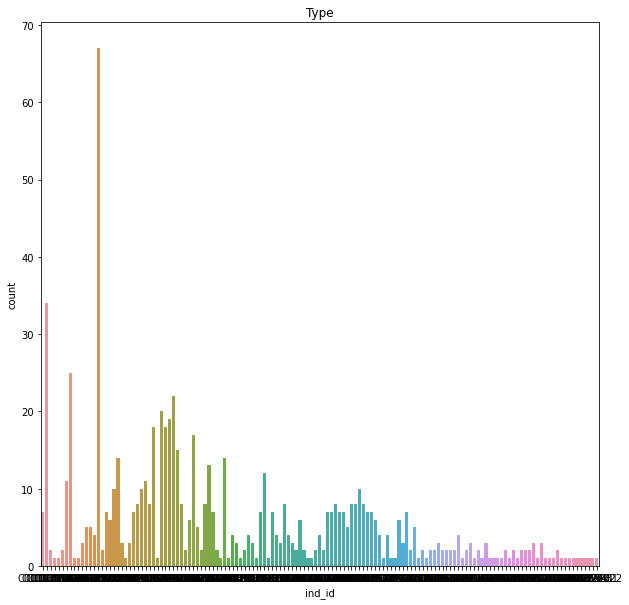

In [4]:
# The frequency of drug-id and indication id

sns.countplot(ass['ind_id'])
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.title('Type')

In [5]:
freq = ass.groupby(['ind_id'])['drug_id'].agg('count').reset_index()
freq = freq.sort_values(by='drug_id', ascending=False)


In [6]:
has = pd.read_csv("my_repodb.txt") # Positive data: Known Drug-Disease associations
has.set_index("Unnamed: 0", inplace=True)
has = has.drop(['drug_name', 'ind_name','NCT','status', 'phase',
       'DetailedStatus'], axis=1)
has = has.loc[has['ind_id'].isin(my_disease_list)]


hasnt = pd.read_csv("my_only_negatives.txt") # Negative data: Unknown Drug-Disease associations when disease is adverse drug reaction
hasnt.set_index("Unnamed: 0", inplace=True)
hasnt = hasnt.rename(columns={"Not_indicated_for":"ind_id", "Drug_id": "drug_id"})
hasnt = hasnt.loc[hasnt['ind_id'].isin(my_disease_list)]


In [7]:
# Positive : Known drug-disease associations
print("The number of all known drug disease associations in our dataset: ",(has.shape))
print("Number of unique disease in Pos: ",len(list(set(has.ind_id))) )
print("Number of uniques drugs in Pos: ", len(list(set(has.drug_id))) )

The number of all known drug disease associations in our dataset:  (748, 2)
Number of unique disease in Pos:  141
Number of uniques drugs in Pos:  410


In [8]:
# Negatives : Unknown drug-disease associations provided the disease is adverse drug reactoins

print("The number of unknown drug disease associations in our dataset: ",(hasnt.shape))
print("Number of unique disease in Neg: ",len(list(set(hasnt.ind_id))) )
print("Number of uniques drugs in Neg: ", len(list(set(hasnt.drug_id))) )

The number of unknown drug disease associations in our dataset:  (1966, 2)
Number of unique disease in Neg:  88
Number of uniques drugs in Neg:  361


The information of diseases are collected using [DisGeNet](https://www.disgenet.org)

In [9]:

# making the relation of diseases: has_geneid, has_class, has_semantic, has_type

C=[]
num1=0
num2=0
num3=0
num4=0
for idx, row in disgenet.iterrows():
      semtype = "_".join(row.diseaseSemanticType.split())
      clas = row.diseaseClass.split(";")
      text1 =str(row.diseaseId)+" has_geneid "+str(row.geneSymbol)+". "
      num1+=1
      text2 =str(row.diseaseId)+" has_type "+str(row.diseaseType)+". "
      num2+=1
      text3 =str(row.diseaseId)+" has_semantic "+str(semtype)+". "
      num3+=1
      C.append(text1)
      C.append(text2)
      C.append(text3)
      num4+=len(clas)
      for cl in clas:
        text =str(row.diseaseId)+" has_class "+str(cl)+". "
        C.append(text)

Disease=""
for c in C:
  Disease= Disease+c


making the drug relations: has_sideeffect, has_target, has_domain, has_atccode, has_chemicalstructure

In [10]:
# has_target relation. data is collected using DrugBank
T=[]
target= pd.read_csv("my_target.txt")
target.set_index("Unnamed: 0", inplace=True)
# target_name = target.columns
for idx, row in target.iterrows():
  for c in target.columns:
    if row[c] ==1 :
      text =str(idx)+" has_target "+str(c)+". "
      T.append(text)
target=""
for c in T:
  target= target+c

In [12]:
# has_domain relation. data is collected using UniProt
D=[]
dom= pd.read_csv("my_domain.txt")
dom.set_index("Unnamed: 0", inplace=True)
for idx, row in dom.iterrows():
  for c in dom.columns:
    if row[c] ==1 :
      text =str(idx)+" has_domain "+str(c)+". "
      D.append(text)

domain=""
for c in D:
  domain= domain+c


In [13]:
# has_chemical relation. data is collected using Pubchem
C=[]
finger= pd.read_csv("my_finger.txt")
finger.set_index("Unnamed: 0", inplace=True)
for idx, row in finger.iterrows():
  for c in finger.columns:
    if row[c] ==1 :
      text =str(idx)+" has_chemical S"+str(c)+". "
      C.append(text)
chemical=""
for c in C:
  chemical= chemical+c

In [14]:
# has_atc_code relation. data is collected using Sider4.1

ATC=[]
atc= pd.read_csv("my_ATC.txt")
atc.set_index("Unnamed: 0", inplace=True)
for idx, row in atc.iterrows():
  for c in atc.columns:
    if row[c] == 1 and (len(c)==4 or len(c)==1 or len(c)==3 or len(c)==5): # we consider first 4 level of ATC code
      text =str(idx)+" has_atc_code "+str(c)+". "
      ATC.append(text)
atccode=""
for c in ATC:
  atccode= atccode+c

In [15]:
# has_sideeffect relation. Date is collected using Sider4.1
S=[]
side= pd.read_csv("my_sideeffect.txt")
side.set_index("Unnamed: 0", inplace=True)
for idx, row in side.iterrows():
  for c in side.columns:
    if row[c] ==1 :
      text =str(idx)+" has_sideeffect "+str(c)+". "
      S.append(text)

Extracting drug-disease associations

Positive data: Known drug-disease associations

Negative data: a subset of unknown drug-disease associations that disease is an adverse drug reaction and common with our side effects

More over I did it 10 times for getting the results of 10-experiments.

In [16]:
A_test=[]
i=0
# randomly chose 10% (74) of positive data for test set
# then extract those pairs from the documnet of associations that word2vec learns
while(i!=74):
  a1 = (random.sample(A, 1))
  a = a1[0].split(" ")
  a2=a[2].split(".")
  A_test.append(a1[0])
  A.remove(a1[0]) # removing the drug-disease pairs that we aim to check their associations by the model
  i+=1

ass="" # making the new associations for training the models
for c in A:
  ass= ass+c

In [17]:

I=[]
for idx, row in has.iterrows():
  text=str(row.drug_id)+" has_indicated "+str(row.ind_id)+". "
  if text in A_test: # Extracting test associations from positive data
    I.append(idx)
has = has.drop(index=I, axis=0)
print("The number of  known drug disease associations without positive test set:",has.shape)

The number of  known drug disease associations without positive test set: (674, 2)


In [18]:
print("The number of unknown drug disease associations in our dataset: ",(hasnt.shape))

I=[]
u=0
hasnt_test_idx=random.sample(range(0,hasnt.shape[0]), 78)
for idx, row in hasnt.iterrows():
  if idx in hasnt_test_idx:
    I.append(row)
    x = str(row.drug_id)+" has_sideeffect "+str(row.ind_id)+". "  # we extract those has_sideeffect relations from drug which are in negative test set and we consider them as adverse drug reactions
    if(x in S):
      S.remove(x)
      u = u+1
hasnt = hasnt.drop(index=hasnt_test_idx, axis=0)
print("The number of unknown drug disease associations without negative test set: ",(hasnt.shape))

side=""
for c in S:
  side= side+c
I=pd.DataFrame(I)

The number of unknown drug disease associations in our dataset:  (1966, 2)
The number of unknown drug disease associations without negative test set:  (1888, 2)


# Data loading -> Keep disease out experiments

Here, every time I divide my disease lists to 10 part. and every time I use 9 parts as train and 1 part as test

In [ ]:
T=[]
dic_dis={}
i=0
for d in my_disease_list:
  dic_dis[i]=d
  i+=1

In [ ]:
def list_of_disease_test(T):
  i=0
  new_test=[]
  while i!=14:
    num = random.randint(0, 140)
    if num in T:
      continue
    else:
      T.append(num)
      new_test.append(num)
      i+=1
  return new_test
  

In [ ]:
test1 = list_of_disease_test(T)
train1 = dic_dis.keys()-test1

test2 = list_of_disease_test(T)
train2 = dic_dis.keys()-test2

test3 = list_of_disease_test(T)
train3 = dic_dis.keys()-test3

test4 = list_of_disease_test(T)
train4 = dic_dis.keys()-test4

test5 = list_of_disease_test(T)
train5 = dic_dis.keys()-test5

test6 = list_of_disease_test(T)
train6 = dic_dis.keys()-test6

test7 = list_of_disease_test(T)
train7 = dic_dis.keys()-test7

test8 = list_of_disease_test(T)
train8 = dic_dis.keys()-test8

test9 = list_of_disease_test(T)
train9 = dic_dis.keys()-test9

test10 = list_of_disease_test(T)
train10 = dic_dis.keys()-test10

In [ ]:
ass = pd.read_csv("my_repodb.txt") 
ass.set_index("Unnamed: 0", inplace=True)
disgenet = pd.read_csv("Gen-Dis-association-Disgenet-2022.csv")

# making the drug and disease lists
my_disease_list = list(set(ass.ind_id))
my_drug_list = list(set(ass.drug_id))
drugs=list(set(ass.drug_id))
disgenet = disgenet.loc[disgenet['diseaseId'].isin(my_disease_list)]
my_disease_list = list(set(disgenet.diseaseId))
ass = ass.loc[ass['ind_id'].isin(my_disease_list)]
my_drug_list = list(set(ass.drug_id))

# making the list of known drug-disease associations 

A=[]
for ix, row in ass.iterrows():
  text = str(row.drug_id)+" has_indicated "+str(row.ind_id)+". "
  A.append(text)

associations = []
for a in A:
  associations.append(a)




In [ ]:
has = pd.read_csv("my_repodb.txt") # Positive data: Known Drug-Disease associations
has.set_index("Unnamed: 0", inplace=True)
has = has.drop(['drug_name', 'ind_name','NCT','status', 'phase',
       'DetailedStatus'], axis=1)
has = has.loc[has['ind_id'].isin(my_disease_list)]


hasnt = pd.read_csv("my_only_negatives.txt") # Negative data: Unknown Drug-Disease associations when disease is adverse drug reaction
hasnt.set_index("Unnamed: 0", inplace=True)
hasnt = hasnt.rename(columns={"Not_indicated_for":"ind_id", "Drug_id": "drug_id"})
hasnt = hasnt.loc[hasnt['ind_id'].isin(my_disease_list)]


In [ ]:
# Positive : Known drug-disease associations
print("The number of all known drug disease associations in our dataset: ",(has.shape))
print("Number of unique disease in Pos: ",len(list(set(has.ind_id))) )
print("Number of uniques drugs in Pos: ", len(list(set(has.drug_id))) )

The number of all known drug disease associations in our dataset:  (748, 2)
Number of unique disease in Pos:  141
Number of uniques drugs in Pos:  410


In [ ]:
# Negatives : Unknown drug-disease associations provided the disease is adverse drug reactoins

print("The number of unknown drug disease associations in our dataset: ",(hasnt.shape))
print("Number of unique disease in Neg: ",len(list(set(hasnt.ind_id))) )
print("Number of uniques drugs in Neg: ", len(list(set(hasnt.drug_id))) )

The number of unknown drug disease associations in our dataset:  (1966, 2)
Number of unique disease in Neg:  88
Number of uniques drugs in Neg:  361


In [ ]:
test_dis = []
train_dis =[]
for i in dic_dis.keys():
  if i in test9:
    test_dis.append(dic_dis[i])
  else:
      train_dis.append(dic_dis[i])

The information of diseases are collected using [DisGeNet](https://www.disgenet.org)

In [ ]:
# making the relation of diseases: has_geneid, has_class, has_semantic, has_type

C=[]
num1=0
num2=0
num3=0
num4=0
for idx, row in disgenet.iterrows():
      semtype = "_".join(row.diseaseSemanticType.split())
      clas = row.diseaseClass.split(";")
      text1 =str(row.diseaseId)+" has_geneid "+str(row.geneSymbol)+". "
      num1+=1
      text2 =str(row.diseaseId)+" has_type "+str(row.diseaseType)+". "
      num2+=1
      text3 =str(row.diseaseId)+" has_semantic "+str(semtype)+". "
      num3+=1
      C.append(text1)
      C.append(text2)
      C.append(text3)
      num4+=len(clas)
      for cl in clas:
        text =str(row.diseaseId)+" has_class "+str(cl)+". "
        C.append(text)

Disease=""
for c in C:
  Disease= Disease+c


making the drug relations: has_sideeffect, has_target, has_domain, has_atccode, has_chemicalstructure

In [ ]:
# has_target relation. data is collected using DrugBank
T=[]
target= pd.read_csv("my_target.txt")
target.set_index("Unnamed: 0", inplace=True)
for idx, row in target.iterrows():
  for c in target.columns:
    if row[c] ==1 :
      text =str(idx)+" has_target "+str(c)+". "
      T.append(text)
target=""
for c in T:
  target= target+c

In [ ]:
# has_domain relation. data is collected using UniProt
D=[]
dom= pd.read_csv("my_domain.txt")
dom.set_index("Unnamed: 0", inplace=True)
for idx, row in dom.iterrows():
  for c in dom.columns:
    if row[c] ==1 :
      text =str(idx)+" has_domain "+str(c)+". "
      D.append(text)

domain=""
for c in D:
  domain= domain+c


In [ ]:
# has_chemical relation. data is collected using Pubchem
C=[]
finger= pd.read_csv("my_finger.txt")
finger.set_index("Unnamed: 0", inplace=True)
for idx, row in finger.iterrows():
  for c in finger.columns:
    if row[c] ==1 :
      text =str(idx)+" has_chemical S"+str(c)+". "
      C.append(text)
chemical=""
for c in C:
  chemical= chemical+c

In [ ]:
# has_atc_code relation. data is collected using Sider4.1

ATC=[]
atc= pd.read_csv("my_ATC.txt")
atc.set_index("Unnamed: 0", inplace=True)
for idx, row in atc.iterrows():
  for c in atc.columns:
    if row[c] == 1 and (len(c)==4 or len(c)==1 or len(c)==3 or len(c)==5): # we consider first 4 level of ATC code
      text =str(idx)+" has_atc_code "+str(c)+". "
      ATC.append(text)
atccode=""
for c in ATC:
  atccode= atccode+c

In [ ]:
# has_sideeffect relation. Date is collected using Sider4.1
S=[]
side= pd.read_csv("my_sideeffect.txt")
side.set_index("Unnamed: 0", inplace=True)
for idx, row in side.iterrows():
  for c in side.columns:
    if row[c] ==1 :
      text =str(idx)+" has_sideeffect "+str(c)+". "
      S.append(text)

Extracting drug-disease associations

Positive data: Known drug-disease associations

Negative data: a subset of unknown drug-disease associations that disease is an adverse drug reaction and common with our side effects

More over I did it 10 times for getting the results of 10-fold cross validation based on positive data

In [ ]:
A_test=[]
i=0
print(len(A))
# randomly chose 10% (74) of positive data for test set
# then extract those pairs from the documnet of associations that word2vec learns
for idx, row in has.iterrows():
  text = str(row.drug_id)+" has_indicated "+str(row.ind_id)+". "
  if row.ind_id in test_dis:
    A.remove(text)
    A_test.append(text)
print(len(A), len(A_test))
ass="" # making the new associations for training the models
for c in A:
  ass= ass+c

748
707 41


In [ ]:
has = has.loc[has['ind_id'].isin(train_dis)]
print("The number of  known drug disease associations without positive test set:",has.shape)

The number of  known drug disease associations without positive test set: (707, 2)


In [ ]:
print("The number of unknown drug disease associations in our dataset: ",(hasnt.shape), len(S))

I=[]
for idx, row in hasnt.iterrows():
  text = str(row.drug_id)+" has_sideeffect "+str(row.ind_id)+". "
  if row.ind_id in test_dis:
    S.remove(text)
    I.append(row)

side=""
for c in S:
  side= side+c
I=pd.DataFrame(I)
hasnt = hasnt.loc[hasnt['ind_id'].isin(train_dis)]
print("The number of  known drug disease associations without positive test set:",hasnt.shape, len(S))

The number of unknown drug disease associations in our dataset:  (1966, 2) 64121
The number of  known drug disease associations without positive test set: (1932, 2) 64087


# Data loading -> Keep Drugs out experiments

Here, every time I divide my disease lists to 10 part. and every time I use 9 parts as train and 1 part as test

In [ ]:
T=[]
dic_drug={}
i=0
for d in my_drug_list:
  dic_drug[i]=d
  i+=1

In [ ]:
def list_of_drug_test(T):
  i=0
  new_test=[]
  while i!=41:
    num = random.randint(0, 410)
    if num in T:
      continue
    else:
      T.append(num)
      new_test.append(num)
      i+=1
  return new_test
  

In [ ]:
test1 = list_of_drug_test(T)

test2 = list_of_drug_test(T)

test3 = list_of_drug_test(T)

test4 = list_of_drug_test(T)

test5 = list_of_drug_test(T)

test6 = list_of_drug_test(T)

test7 = list_of_drug_test(T)

test8 = list_of_drug_test(T)

test9 = list_of_drug_test(T)

test10 = list_of_drug_test(T)


In [ ]:
ass = pd.read_csv("my_repodb.txt") 
ass.set_index("Unnamed: 0", inplace=True)
disgenet = pd.read_csv("Gen-Dis-association-Disgenet-2022.csv")

# making the drug and disease lists
my_disease_list = list(set(ass.ind_id))
my_drug_list = list(set(ass.drug_id))
drugs=list(set(ass.drug_id))
disgenet = disgenet.loc[disgenet['diseaseId'].isin(my_disease_list)]
my_disease_list = list(set(disgenet.diseaseId))
ass = ass.loc[ass['ind_id'].isin(my_disease_list)]
my_drug_list = list(set(ass.drug_id))

# making the list of known drug-disease associations 

A=[]
for ix, row in ass.iterrows():
  text = str(row.drug_id)+" has_indicated "+str(row.ind_id)+". "
  A.append(text)

associations = []
for a in A:
  associations.append(a)




In [ ]:
has = pd.read_csv("my_repodb.txt") # Positive data: Known Drug-Disease associations
has.set_index("Unnamed: 0", inplace=True)
has = has.drop(['drug_name', 'ind_name','NCT','status', 'phase',
       'DetailedStatus'], axis=1)
has = has.loc[has['ind_id'].isin(my_disease_list)]


hasnt = pd.read_csv("my_only_negatives.txt") # Negative data: Unknown Drug-Disease associations when disease is adverse drug reaction
hasnt.set_index("Unnamed: 0", inplace=True)
hasnt = hasnt.rename(columns={"Not_indicated_for":"ind_id", "Drug_id": "drug_id"})
hasnt = hasnt.loc[hasnt['ind_id'].isin(my_disease_list)]


In [ ]:
# Positive : Known drug-disease associations
print("The number of all known drug disease associations in our dataset: ",(has.shape))
print("Number of unique disease in Pos: ",len(list(set(has.ind_id))) )
print("Number of uniques drugs in Pos: ", len(list(set(has.drug_id))) )

The number of all known drug disease associations in our dataset:  (748, 2)
Number of unique disease in Pos:  141
Number of uniques drugs in Pos:  410


In [ ]:
# Negatives : Unknown drug-disease associations provided the disease is adverse drug reactoins

print("The number of unknown drug disease associations in our dataset: ",(hasnt.shape))
print("Number of unique disease in Neg: ",len(list(set(hasnt.ind_id))) )
print("Number of uniques drugs in Neg: ", len(list(set(hasnt.drug_id))) )

The number of unknown drug disease associations in our dataset:  (1966, 2)
Number of unique disease in Neg:  88
Number of uniques drugs in Neg:  361


In [ ]:
test_drug = []
train_drug =[]
for i in dic_drug.keys():
  if i in test1:
    test_drug.append(dic_drug[i])
  else:
      train_drug.append(dic_drug[i])

The information of diseases are collected using [DisGeNet](https://www.disgenet.org)

In [ ]:
# making the relation of diseases: has_geneid, has_class, has_semantic, has_type

C=[]
num1=0
num2=0
num3=0
num4=0
for idx, row in disgenet.iterrows():
      semtype = "_".join(row.diseaseSemanticType.split())
      clas = row.diseaseClass.split(";")
      text1 =str(row.diseaseId)+" has_geneid "+str(row.geneSymbol)+". "
      num1+=1
      text2 =str(row.diseaseId)+" has_type "+str(row.diseaseType)+". "
      num2+=1
      text3 =str(row.diseaseId)+" has_semantic "+str(semtype)+". "
      num3+=1
      C.append(text1)
      C.append(text2)
      C.append(text3)
      num4+=len(clas)
      for cl in clas:
        text =str(row.diseaseId)+" has_class "+str(cl)+". "
        C.append(text)

Disease=""
for c in C:
  Disease= Disease+c


making the drug relations: has_sideeffect, has_target, has_domain, has_atccode, has_chemicalstructure

In [ ]:
# has_target relation. data is collected using DrugBank
T=[]
target= pd.read_csv("my_target.txt")
target.set_index("Unnamed: 0", inplace=True)
for idx, row in target.iterrows():
  for c in target.columns:
    if row[c] ==1 :
      text =str(idx)+" has_target "+str(c)+". "
      T.append(text)
target=""
for c in T:
  target= target+c

In [ ]:
# has_domain relation. data is collected using UniProt
D=[]
dom= pd.read_csv("my_domain.txt")
dom.set_index("Unnamed: 0", inplace=True)
for idx, row in dom.iterrows():
  for c in dom.columns:
    if row[c] ==1 :
      text =str(idx)+" has_domain "+str(c)+". "
      D.append(text)

domain=""
for c in D:
  domain= domain+c


In [ ]:
# has_chemical relation. data is collected using Pubchem
C=[]
finger= pd.read_csv("my_finger.txt")
finger.set_index("Unnamed: 0", inplace=True)
for idx, row in finger.iterrows():
  for c in finger.columns:
    if row[c] ==1 :
      text =str(idx)+" has_chemical S"+str(c)+". "
      C.append(text)
chemical=""
for c in C:
  chemical= chemical+c

In [ ]:
# has_atc_code relation. data is collected using Sider4.1

ATC=[]
atc= pd.read_csv("my_ATC.txt")
atc.set_index("Unnamed: 0", inplace=True)
for idx, row in atc.iterrows():
  for c in atc.columns:
    if row[c] == 1 and (len(c)==4 or len(c)==1 or len(c)==3 or len(c)==5): # we consider first 4 level of ATC code
      text =str(idx)+" has_atc_code "+str(c)+". "
      ATC.append(text)
atccode=""
for c in ATC:
  atccode= atccode+c

In [ ]:
# has_sideeffect relation. Date is collected using Sider4.1
S=[]
side= pd.read_csv("my_sideeffect.txt")
side.set_index("Unnamed: 0", inplace=True)
for idx, row in side.iterrows():
  for c in side.columns:
    if row[c] ==1 :
      text =str(idx)+" has_sideeffect "+str(c)+". "
      S.append(text)

Extracting drug-disease associations

Positive data: Known drug-disease associations

Negative data: a subset of unknown drug-disease associations that disease is an adverse drug reaction and common with our side effects

More over I did it 10 times for getting the results of 10-fold cross validation based on positive data

In [ ]:
A_test=[]
i=0
print(len(A))

for idx, row in has.iterrows():
  text = str(row.drug_id)+" has_indicated "+str(row.ind_id)+". "
  if row.drug_id in test_drug:
    A.remove(text)
    A_test.append(text)
print(len(A), len(A_test))
ass="" # making the new associations for training the models
for c in A:
  ass= ass+c

748
707 41


In [ ]:
has = has.loc[has['drug_id'].isin(train_drug)]
print("The number of  known drug disease associations without positive test set:",has.shape)

The number of  known drug disease associations without positive test set: (669, 2)


In [ ]:
print("The number of unknown drug disease associations in our dataset: ",(hasnt.shape), len(S))

I=[]
for idx, row in hasnt.iterrows():
  text = str(row.drug_id)+" has_sideeffect "+str(row.ind_id)+". "
  if row.drug_id in test_drug:
    S.remove(text)
    I.append(row)

side=""
for c in S:
  side= side+c
I=pd.DataFrame(I)
hasnt = hasnt.loc[hasnt['drug_id'].isin(train_drug)]
print("The number of  known drug disease associations without positive test set:",hasnt.shape, len(S))

The number of unknown drug disease associations in our dataset:  (1966, 2) 64121
The number of  known drug disease associations without positive test set: (1932, 2) 64087


# Data loading -> 10 fold cross-validation -> Stratified

Here, every time I divide my disease lists to 10 part. and every time I use 9 parts as train and 1 part as test

In [ ]:
ass = pd.read_csv("my_repodb.txt") 
ass.set_index("Unnamed: 0", inplace=True)
disgenet = pd.read_csv("Gen-Dis-association-Disgenet-2022.csv")

# making the drug and disease lists
my_disease_list = list(set(ass.ind_id))
my_drug_list = list(set(ass.drug_id))
drugs=list(set(ass.drug_id))
disgenet = disgenet.loc[disgenet['diseaseId'].isin(my_disease_list)]
my_disease_list = list(set(disgenet.diseaseId))
ass = ass.loc[ass['ind_id'].isin(my_disease_list)]
my_drug_list = list(set(ass.drug_id))

has = pd.read_csv("my_repodb.txt") # Positive data: Known Drug-Disease associations
has.set_index("Unnamed: 0", inplace=True)
has = has.drop(['drug_name', 'ind_name','NCT','status', 'phase',
       'DetailedStatus'], axis=1)
has = has.loc[has['ind_id'].isin(my_disease_list)]


hasnt = pd.read_csv("my_only_negatives.txt") # Negative data: Unknown Drug-Disease associations when disease is adverse drug reaction
hasnt.set_index("Unnamed: 0", inplace=True)
hasnt = hasnt.rename(columns={"Not_indicated_for":"ind_id", "Drug_id": "drug_id"})
hasnt = hasnt.loc[hasnt['ind_id'].isin(my_disease_list)]


pos_index = has.index
neg_index = hasnt.index
T_pos = []  # To keep the selected indexes of positive pairs and prevnt their selection in the next test set
T_neg = []

In [ ]:
def list_of_pos_test(T_pos):
  i=0
  new_test=[]
  while i!=74:
    num = random.randint(0, len(pos_index)-1)
    if pos_index[num] in T_pos:
      continue
    else:
      T_pos.append(pos_index[num])
      new_test.append(pos_index[num])
      i+=1
  return new_test
  

In [ ]:
def list_of_neg_test(T_neg):
  i=0
  new_test=[]
  while i!=196:
    num = random.randint(0, len(neg_index)-1)
    if neg_index[num] in T_neg:
      continue
    else:
      T_neg.append(neg_index[num])
      new_test.append(neg_index[num])
      i+=1
  return new_test

In [ ]:
# In this step, we divide our positive and negative pairs to 10 fold
# Caution: This step should repeat only one time

testP1 = list_of_pos_test(T_pos)
testN1 = list_of_neg_test(T_neg)

testP2 = list_of_pos_test(T_pos)
testN2 = list_of_neg_test(T_neg)

testP3 = list_of_pos_test(T_pos)
testN3 = list_of_neg_test(T_neg)

testP4 = list_of_pos_test(T_pos)
testN4 = list_of_neg_test(T_neg)

testP5 = list_of_pos_test(T_pos)
testN5 = list_of_neg_test(T_neg)

testP6 = list_of_pos_test(T_pos)
testN6 = list_of_neg_test(T_neg)

testP7 = list_of_pos_test(T_pos)
testN7 = list_of_neg_test(T_neg)

testP8 = list_of_pos_test(T_pos)
testN8 = list_of_neg_test(T_neg)

testP9 = list_of_pos_test(T_pos)
testN9 = list_of_neg_test(T_neg)

testP10 = list_of_pos_test(T_pos)
testN10 = list_of_neg_test(T_neg)


In [ ]:
ass = pd.read_csv("my_repodb.txt") 
ass.set_index("Unnamed: 0", inplace=True)
disgenet = pd.read_csv("Gen-Dis-association-Disgenet-2022.csv")

# making the drug and disease lists
my_disease_list = list(set(ass.ind_id))
my_drug_list = list(set(ass.drug_id))
drugs=list(set(ass.drug_id))
disgenet = disgenet.loc[disgenet['diseaseId'].isin(my_disease_list)]
my_disease_list = list(set(disgenet.diseaseId))
ass = ass.loc[ass['ind_id'].isin(my_disease_list)]
my_drug_list = list(set(ass.drug_id))

# making the list of known drug-disease associations 

A=[]
for ix, row in ass.iterrows():
  text = str(row.drug_id)+" has_indicated "+str(row.ind_id)+". "
  A.append(text)

associations = []
for a in A:
  associations.append(a)




In [ ]:
has = pd.read_csv("my_repodb.txt") # Positive data: Known Drug-Disease associations
has.set_index("Unnamed: 0", inplace=True)
has = has.drop(['drug_name', 'ind_name','NCT','status', 'phase',
       'DetailedStatus'], axis=1)
has = has.loc[has['ind_id'].isin(my_disease_list)]


hasnt = pd.read_csv("my_only_negatives.txt") # Negative data: Unknown Drug-Disease associations when disease is adverse drug reaction
hasnt.set_index("Unnamed: 0", inplace=True)
hasnt = hasnt.rename(columns={"Not_indicated_for":"ind_id", "Drug_id": "drug_id"})
hasnt = hasnt.loc[hasnt['ind_id'].isin(my_disease_list)]


In [ ]:
# Positive : Known drug-disease associations
print("The number of all known drug disease associations in our dataset: ",(has.shape))
print("Number of unique disease in Pos: ",len(list(set(has.ind_id))) )
print("Number of uniques drugs in Pos: ", len(list(set(has.drug_id))) )

The number of all known drug disease associations in our dataset:  (748, 2)
Number of unique disease in Pos:  141
Number of uniques drugs in Pos:  410


In [ ]:
# Negatives : Unknown drug-disease associations provided the disease is adverse drug reactoins

print("The number of unknown drug disease associations in our dataset: ",(hasnt.shape))
print("Number of unique disease in Neg: ",len(list(set(hasnt.ind_id))) )
print("Number of uniques drugs in Neg: ", len(list(set(hasnt.drug_id))) )

The number of unknown drug disease associations in our dataset:  (1966, 2)
Number of unique disease in Neg:  88
Number of uniques drugs in Neg:  361


The information of diseases are collected using [DisGeNet](https://www.disgenet.org)

In [ ]:
# making the relation of diseases: has_geneid, has_class, has_semantic, has_type

C=[]
num1=0
num2=0
num3=0
num4=0
for idx, row in disgenet.iterrows():
      semtype = "_".join(row.diseaseSemanticType.split())
      clas = row.diseaseClass.split(";")
      text1 =str(row.diseaseId)+" has_geneid "+str(row.geneSymbol)+". "
      num1+=1
      text2 =str(row.diseaseId)+" has_type "+str(row.diseaseType)+". "
      num2+=1
      text3 =str(row.diseaseId)+" has_semantic "+str(semtype)+". "
      num3+=1
      C.append(text1)
      C.append(text2)
      C.append(text3)
      num4+=len(clas)
      for cl in clas:
        text =str(row.diseaseId)+" has_class "+str(cl)+". "
        C.append(text)

Disease=""
for c in C:
  Disease= Disease+c


making the drug relations: has_sideeffect, has_target, has_domain, has_atccode, has_chemicalstructure

In [ ]:
# has_target relation. data is collected using DrugBank
T=[]
target= pd.read_csv("my_target.txt")
target.set_index("Unnamed: 0", inplace=True)
for idx, row in target.iterrows():
  for c in target.columns:
    if row[c] ==1 :
      text =str(idx)+" has_target "+str(c)+". "
      T.append(text)
target=""
for c in T:
  target= target+c

In [ ]:
# has_domain relation. data is collected using UniProt
D=[]
dom= pd.read_csv("my_domain.txt")
dom.set_index("Unnamed: 0", inplace=True)
for idx, row in dom.iterrows():
  for c in dom.columns:
    if row[c] ==1 :
      text =str(idx)+" has_domain "+str(c)+". "
      D.append(text)

domain=""
for c in D:
  domain= domain+c


In [ ]:
# has_chemical relation. data is collected using Pubchem
C=[]
finger= pd.read_csv("my_finger.txt")
finger.set_index("Unnamed: 0", inplace=True)
for idx, row in finger.iterrows():
  for c in finger.columns:
    if row[c] ==1 :
      text =str(idx)+" has_chemical S"+str(c)+". "
      C.append(text)
chemical=""
for c in C:
  chemical= chemical+c

In [ ]:
# has_atc_code relation. data is collected using Sider4.1

ATC=[]
atc= pd.read_csv("my_ATC.txt")
atc.set_index("Unnamed: 0", inplace=True)
for idx, row in atc.iterrows():
  for c in atc.columns:
    if row[c] == 1 and (len(c)==4 or len(c)==1 or len(c)==3 or len(c)==5): # we consider first 4 level of ATC code
      text =str(idx)+" has_atc_code "+str(c)+". "
      ATC.append(text)
atccode=""
for c in ATC:
  atccode= atccode+c

In [ ]:
# has_sideeffect relation. Date is collected using Sider4.1
S=[]
side= pd.read_csv("my_sideeffect.txt")
side.set_index("Unnamed: 0", inplace=True)
for idx, row in side.iterrows():
  for c in side.columns:
    if row[c] ==1 :
      text =str(idx)+" has_sideeffect "+str(c)+". "
      S.append(text)

Extracting drug-disease associations

Positive data: Known drug-disease associations

Negative data: a subset of unknown drug-disease associations that disease is an adverse drug reaction and common with our side effects

More over I did it 10 times for getting the results of 10-fold cross validation based on positive data

In [ ]:
# to make the positive test set, every time we only change the name of testPi, 1<=i<=10

A_test=[]
i=0
print(len(A))

for idx, row in has.iterrows():
  text = str(row.drug_id)+" has_indicated "+str(row.ind_id)+". "
  if idx in testP1:   # HERE we change the number of i for  i<=i<=10
    A.remove(text)
    A_test.append(text)
print(len(A), len(A_test))
ass="" # making the new associations for training the models
for c in A:
  ass= ass+c

has = has.drop(testP1)  # HERE we change the number of i for 1<=i<=10
print("The number of  known drug disease associations without positive test set:",has.shape)

748
707 41


In [ ]:
# The negative training and test set based on testNi for 1<=i<=10

print("The number of unknown drug disease associations in our dataset: ",(hasnt.shape), len(S))

I=[]
for idx, row in hasnt.iterrows():
  text = str(row.drug_id)+" has_sideeffect "+str(row.ind_id)+". "
  if idx in testN1:   # HERE we change the number of i for 1<=i<=10
    S.remove(text)
    I.append(row)

side=""
for c in S:
  side= side+c
I=pd.DataFrame(I)
hasnt = hasnt.drop(testN1)   # HERE we change the number of i for 1<=i<=10
print("The number of  known drug disease associations without positive test set:",hasnt.shape, len(S))

The number of unknown drug disease associations in our dataset:  (1966, 2) 64121
The number of  known drug disease associations without positive test set: (1932, 2) 64087


# Data loading -> 10 fold cross-validation -> BALANCED

Here, every time I divide my disease lists to 10 part. and every time I use 9 parts as train and 1 part as test

In [ ]:
ass = pd.read_csv("my_repodb.txt") 
ass.set_index("Unnamed: 0", inplace=True)
disgenet = pd.read_csv("Gen-Dis-association-Disgenet-2022.csv")

# making the drug and disease lists
my_disease_list = list(set(ass.ind_id))
my_drug_list = list(set(ass.drug_id))
drugs=list(set(ass.drug_id))
disgenet = disgenet.loc[disgenet['diseaseId'].isin(my_disease_list)]
my_disease_list = list(set(disgenet.diseaseId))
ass = ass.loc[ass['ind_id'].isin(my_disease_list)]
my_drug_list = list(set(ass.drug_id))

has = pd.read_csv("my_repodb.txt") # Positive data: Known Drug-Disease associations
has.set_index("Unnamed: 0", inplace=True)
has = has.drop(['drug_name', 'ind_name','NCT','status', 'phase',
       'DetailedStatus'], axis=1)
has = has.loc[has['ind_id'].isin(my_disease_list)]


hasnt = pd.read_csv("my_only_negatives.txt") # Negative data: Unknown Drug-Disease associations when disease is adverse drug reaction
hasnt.set_index("Unnamed: 0", inplace=True)
hasnt = hasnt.rename(columns={"Not_indicated_for":"ind_id", "Drug_id": "drug_id"})
hasnt = hasnt.loc[hasnt['ind_id'].isin(my_disease_list)]


pos_index = has.index
neg_index = hasnt.index
T_pos = []  # To keep the selected indexes of positive pairs and prevnt their selection in the next test set
T_neg = []

In [ ]:
def list_of_pos_test(T_pos):
  i=0
  new_test=[]
  while i!=74:
    num = random.randint(0, len(pos_index)-1)
    if pos_index[num] in T_pos:
      continue
    else:
      T_pos.append(pos_index[num])
      new_test.append(pos_index[num])
      i+=1
  return new_test
  

In [ ]:
def list_of_neg_test(T_neg):
  i=0
  new_test=[]
  while i!=74:
    num = random.randint(0, len(neg_index)-1)
    if neg_index[num] in T_neg:
      continue
    else:
      T_neg.append(neg_index[num])
      new_test.append(neg_index[num])
      i+=1
  return new_test

In [ ]:
# In this step, we divide our positive and negative pairs to 10 fold
# Caution: This step should repeat only one time

testP1 = list_of_pos_test(T_pos)
testN1 = list_of_neg_test(T_neg)

testP2 = list_of_pos_test(T_pos)
testN2 = list_of_neg_test(T_neg)

testP3 = list_of_pos_test(T_pos)
testN3 = list_of_neg_test(T_neg)

testP4 = list_of_pos_test(T_pos)
testN4 = list_of_neg_test(T_neg)

testP5 = list_of_pos_test(T_pos)
testN5 = list_of_neg_test(T_neg)

testP6 = list_of_pos_test(T_pos)
testN6 = list_of_neg_test(T_neg)

testP7 = list_of_pos_test(T_pos)
testN7 = list_of_neg_test(T_neg)

testP8 = list_of_pos_test(T_pos)
testN8 = list_of_neg_test(T_neg)

testP9 = list_of_pos_test(T_pos)
testN9 = list_of_neg_test(T_neg)

testP10 = list_of_pos_test(T_pos)
testN10 = list_of_neg_test(T_neg)


In [ ]:
ass = pd.read_csv("my_repodb.txt") 
ass.set_index("Unnamed: 0", inplace=True)
disgenet = pd.read_csv("Gen-Dis-association-Disgenet-2022.csv")

# making the drug and disease lists
my_disease_list = list(set(ass.ind_id))
my_drug_list = list(set(ass.drug_id))
drugs=list(set(ass.drug_id))
disgenet = disgenet.loc[disgenet['diseaseId'].isin(my_disease_list)]
my_disease_list = list(set(disgenet.diseaseId))
ass = ass.loc[ass['ind_id'].isin(my_disease_list)]
my_drug_list = list(set(ass.drug_id))

# making the list of known drug-disease associations 

A=[]
for ix, row in ass.iterrows():
  text = str(row.drug_id)+" has_indicated "+str(row.ind_id)+". "
  A.append(text)

associations = []
for a in A:
  associations.append(a)




In [ ]:
has = pd.read_csv("my_repodb.txt") # Positive data: Known Drug-Disease associations
has.set_index("Unnamed: 0", inplace=True)
has = has.drop(['drug_name', 'ind_name','NCT','status', 'phase',
       'DetailedStatus'], axis=1)
has = has.loc[has['ind_id'].isin(my_disease_list)]


hasnt = pd.read_csv("my_only_negatives.txt") # Negative data: Unknown Drug-Disease associations when disease is adverse drug reaction
hasnt.set_index("Unnamed: 0", inplace=True)
hasnt = hasnt.rename(columns={"Not_indicated_for":"ind_id", "Drug_id": "drug_id"})
hasnt = hasnt.loc[hasnt['ind_id'].isin(my_disease_list)]


In [ ]:
# Positive : Known drug-disease associations
print("The number of all known drug disease associations in our dataset: ",(has.shape))
print("Number of unique disease in Pos: ",len(list(set(has.ind_id))) )
print("Number of uniques drugs in Pos: ", len(list(set(has.drug_id))) )

The number of all known drug disease associations in our dataset:  (748, 2)
Number of unique disease in Pos:  141
Number of uniques drugs in Pos:  410


In [ ]:
# Negatives : Unknown drug-disease associations provided the disease is adverse drug reactoins

print("The number of unknown drug disease associations in our dataset: ",(hasnt.shape))
print("Number of unique disease in Neg: ",len(list(set(hasnt.ind_id))) )
print("Number of uniques drugs in Neg: ", len(list(set(hasnt.drug_id))) )

The number of unknown drug disease associations in our dataset:  (1966, 2)
Number of unique disease in Neg:  88
Number of uniques drugs in Neg:  361


The information of diseases are collected using [DisGeNet](https://www.disgenet.org)

In [ ]:
# making the relation of diseases: has_geneid, has_class, has_semantic, has_type

C=[]
num1=0
num2=0
num3=0
num4=0
for idx, row in disgenet.iterrows():
      semtype = "_".join(row.diseaseSemanticType.split())
      clas = row.diseaseClass.split(";")
      text1 =str(row.diseaseId)+" has_geneid "+str(row.geneSymbol)+". "
      num1+=1
      text2 =str(row.diseaseId)+" has_type "+str(row.diseaseType)+". "
      num2+=1
      text3 =str(row.diseaseId)+" has_semantic "+str(semtype)+". "
      num3+=1
      C.append(text1)
      C.append(text2)
      C.append(text3)
      num4+=len(clas)
      for cl in clas:
        text =str(row.diseaseId)+" has_class "+str(cl)+". "
        C.append(text)

Disease=""
for c in C:
  Disease= Disease+c


making the drug relations: has_sideeffect, has_target, has_domain, has_atccode, has_chemicalstructure

In [ ]:
# has_target relation. data is collected using DrugBank
T=[]
target= pd.read_csv("my_target.txt")
target.set_index("Unnamed: 0", inplace=True)
for idx, row in target.iterrows():
  for c in target.columns:
    if row[c] ==1 :
      text =str(idx)+" has_target "+str(c)+". "
      T.append(text)
target=""
for c in T:
  target= target+c

In [ ]:
# has_domain relation. data is collected using UniProt
D=[]
dom= pd.read_csv("my_domain.txt")
dom.set_index("Unnamed: 0", inplace=True)
for idx, row in dom.iterrows():
  for c in dom.columns:
    if row[c] ==1 :
      text =str(idx)+" has_domain "+str(c)+". "
      D.append(text)

domain=""
for c in D:
  domain= domain+c


In [ ]:
# has_chemical relation. data is collected using Pubchem
C=[]
finger= pd.read_csv("my_finger.txt")
finger.set_index("Unnamed: 0", inplace=True)
for idx, row in finger.iterrows():
  for c in finger.columns:
    if row[c] ==1 :
      text =str(idx)+" has_chemical S"+str(c)+". "
      C.append(text)
chemical=""
for c in C:
  chemical= chemical+c

In [ ]:
# has_atc_code relation. data is collected using Sider4.1

ATC=[]
atc= pd.read_csv("my_ATC.txt")
atc.set_index("Unnamed: 0", inplace=True)
for idx, row in atc.iterrows():
  for c in atc.columns:
    if row[c] == 1 and (len(c)==4 or len(c)==1 or len(c)==3 or len(c)==5): # we consider first 4 level of ATC code
      text =str(idx)+" has_atc_code "+str(c)+". "
      ATC.append(text)
atccode=""
for c in ATC:
  atccode= atccode+c

In [ ]:
# has_sideeffect relation. Date is collected using Sider4.1
S=[]
side= pd.read_csv("my_sideeffect.txt")
side.set_index("Unnamed: 0", inplace=True)
for idx, row in side.iterrows():
  for c in side.columns:
    if row[c] ==1 :
      text =str(idx)+" has_sideeffect "+str(c)+". "
      S.append(text)

Extracting drug-disease associations

Positive data: Known drug-disease associations

Negative data: a subset of unknown drug-disease associations that disease is an adverse drug reaction and common with our side effects

More over I did it 10 times for getting the results of 10-fold cross validation based on positive data

In [ ]:
# to make the positive test set, every time we only change the name of testPi, 1<=i<=10

A_test=[]
i=0
print(len(A))

for idx, row in has.iterrows():
  text = str(row.drug_id)+" has_indicated "+str(row.ind_id)+". "
  if idx in testP10:   # HERE we change the number of i for  i<=i<=10
    A.remove(text)
    A_test.append(text)
print(len(A), len(A_test))
ass="" # making the new associations for training the models
for c in A:
  ass= ass+c

has = has.drop(testP10)  # HERE we change the number of i for 1<=i<=10
print("The number of  known drug disease associations without positive test set:",has.shape)

748
674 74
The number of  known drug disease associations without positive test set: (674, 2)


In [ ]:
# The negative training and test set based on testNi for 1<=i<=10

print("The number of unknown drug disease associations in our dataset: ",(hasnt.shape), len(S))

I=[]
for idx, row in hasnt.iterrows():
  text = str(row.drug_id)+" has_sideeffect "+str(row.ind_id)+". "
  if idx in testN10:   # HERE we change the number of i for 1<=i<=10
    S.remove(text)
    I.append(row)

side=""
for c in S:
  side= side+c
I=pd.DataFrame(I)
hasnt = hasnt.drop(testN10)   # HERE we change the number of i for 1<=i<=10
print("The number of  known drug disease associations without positive test set:",hasnt.shape, len(S))

The number of unknown drug disease associations in our dataset:  (1966, 2) 64121
The number of  known drug disease associations without positive test set: (1892, 2) 64047


# Data loading -> The test set of DRP-VEM

In [ ]:
ass = pd.read_csv("my_repodb.txt") 
ass.set_index("Unnamed: 0", inplace=True)
disgenet = pd.read_csv("Gen-Dis-association-Disgenet-2022.csv")

# making the drug and disease lists
my_disease_list = list(set(ass.ind_id))
my_drug_list = list(set(ass.drug_id))
drugs=list(set(ass.drug_id))
disgenet = disgenet.loc[disgenet['diseaseId'].isin(my_disease_list)]
my_disease_list = list(set(disgenet.diseaseId))
ass = ass.loc[ass['ind_id'].isin(my_disease_list)]
my_drug_list = list(set(ass.drug_id))

# making the list of known drug-disease associations 

A=[]
for ix, row in ass.iterrows():
  text = str(row.drug_id)+" has_indicated "+str(row.ind_id)+". "
  A.append(text)

associations = []
for a in A:
  associations.append(a)




In [ ]:
def list_of_pos_test(T_pos):
  i=0
  new_test=[]
  while i!=74:
    num = random.randint(0, len(pos_index)-1)
    if pos_index[num] in T_pos:
      continue
    else:
      T_pos.append(pos_index[num])
      new_test.append(pos_index[num])
      i+=1
  return new_test
  

In [ ]:
def list_of_neg_test(T_neg):
  i=0
  new_test=[]
  while i!=74:
    num = random.randint(0, len(neg_index)-1)
    if neg_index[num] in T_neg:
      continue
    else:
      T_neg.append(neg_index[num])
      new_test.append(neg_index[num])
      i+=1
  return new_test

In [ ]:
has = pd.read_csv("my_repodb.txt") # Positive data: Known Drug-Disease associations
has.set_index("Unnamed: 0", inplace=True)
has = has.drop(['drug_name', 'ind_name','NCT','status', 'phase',
       'DetailedStatus'], axis=1)
has = has.loc[has['ind_id'].isin(my_disease_list)]


hasnt = pd.read_csv("my_only_negatives.txt") # Negative data: Unknown Drug-Disease associations when disease is adverse drug reaction
hasnt.set_index("Unnamed: 0", inplace=True)
hasnt = hasnt.rename(columns={"Not_indicated_for":"ind_id", "Drug_id": "drug_id"})
hasnt = hasnt.loc[hasnt['ind_id'].isin(my_disease_list)]

pos_index = has.index
neg_index = hasnt.index


In [ ]:
T_pos = []
T_neg = []

test_positive = list_of_pos_test(T_pos)
test_negative = list_of_neg_test(T_neg)

The information of diseases are collected using [DisGeNet](https://www.disgenet.org)

In [ ]:
# making the relation of diseases: has_geneid, has_class, has_semantic, has_type

C=[]
num1=0
num2=0
num3=0
num4=0
for idx, row in disgenet.iterrows():
      semtype = "_".join(row.diseaseSemanticType.split())
      clas = row.diseaseClass.split(";")
      text1 =str(row.diseaseId)+" has_geneid "+str(row.geneSymbol)+". "
      num1+=1
      text2 =str(row.diseaseId)+" has_type "+str(row.diseaseType)+". "
      num2+=1
      text3 =str(row.diseaseId)+" has_semantic "+str(semtype)+". "
      num3+=1
      C.append(text1)
      C.append(text2)
      C.append(text3)
      num4+=len(clas)
      for cl in clas:
        text =str(row.diseaseId)+" has_class "+str(cl)+". "
        C.append(text)

Disease=""
for c in C:
  Disease= Disease+c


making the drug relations: has_sideeffect, has_target, has_domain, has_atccode, has_chemicalstructure

In [ ]:
# has_target relation. data is collected using DrugBank
T=[]
target= pd.read_csv("my_target.txt")
target.set_index("Unnamed: 0", inplace=True)
# target_name = target.columns
for idx, row in target.iterrows():
  for c in target.columns:
    if row[c] ==1 :
      text =str(idx)+" has_target "+str(c)+". "
      T.append(text)
target=""
for c in T:
  target= target+c

In [ ]:
# has_domain relation. data is collected using UniProt
D=[]
dom= pd.read_csv("my_domain.txt")
dom.set_index("Unnamed: 0", inplace=True)
for idx, row in dom.iterrows():
  for c in dom.columns:
    if row[c] ==1 :
      text =str(idx)+" has_domain "+str(c)+". "
      D.append(text)

domain=""
for c in D:
  domain= domain+c


In [ ]:
# has_chemical relation. data is collected using Pubchem
C=[]
finger= pd.read_csv("my_finger.txt")
finger.set_index("Unnamed: 0", inplace=True)
for idx, row in finger.iterrows():
  for c in finger.columns:
    if row[c] ==1 :
      text =str(idx)+" has_chemical S"+str(c)+". "
      C.append(text)
chemical=""
for c in C:
  chemical= chemical+c

In [ ]:
# has_atc_code relation. data is collected using Sider4.1

ATC=[]
atc= pd.read_csv("my_ATC.txt")
atc.set_index("Unnamed: 0", inplace=True)
for idx, row in atc.iterrows():
  for c in atc.columns:
    if row[c] == 1 and (len(c)==4 or len(c)==1 or len(c)==3 or len(c)==5): # we consider first 4 level of ATC code
      text =str(idx)+" has_atc_code "+str(c)+". "
      ATC.append(text)
atccode=""
for c in ATC:
  atccode= atccode+c

In [ ]:
# has_sideeffect relation. Date is collected using Sider4.1
S=[]
side= pd.read_csv("my_sideeffect.txt")
side.set_index("Unnamed: 0", inplace=True)
for idx, row in side.iterrows():
  for c in side.columns:
    if row[c] ==1 :
      text =str(idx)+" has_sideeffect "+str(c)+". "
      S.append(text)

In [ ]:
# to make the positive test set, every time we only change the name of testPi, 1<=i<=10

A_test=[]
i=0
print(len(A))

for idx, row in has.iterrows():
  text = str(row.drug_id)+" has_indicated "+str(row.ind_id)+". "
  if idx in test_positive:   # HERE we change the number of i for  i<=i<=10
    A.remove(text)
    A_test.append(text)
print(len(A), len(A_test))
ass="" # making the new associations for training the models
for c in A:
  ass= ass+c

has = has.drop(test_positive)  # HERE we change the number of i for 1<=i<=10
print("The number of  known drug disease associations without positive test set:",has.shape)

748
674 74
The number of  known drug disease associations without positive test set: (674, 2)


In [ ]:
# The negative training and test set based on testNi for 1<=i<=10

print("The number of unknown drug disease associations in our dataset: ",(hasnt.shape), len(S))

I=[]
for idx, row in hasnt.iterrows():
  text = str(row.drug_id)+" has_sideeffect "+str(row.ind_id)+". "
  if idx in test_negative:   # HERE we change the number of i for 1<=i<=10
    S.remove(text)
    I.append(row)

side=""
for c in S:
  side= side+c
I=pd.DataFrame(I)
hasnt = hasnt.drop(test_negative)   # HERE we change the number of i for 1<=i<=10
print("The number of  known drug disease associations without positive test set:",hasnt.shape, len(S))

The number of unknown drug disease associations in our dataset:  (1966, 2) 64121
The number of  known drug disease associations without positive test set: (1892, 2) 64047


# Checking the roubustness of model based on article 'Drug-Disease Association Prediction Using Heterogeneous Networks for Computational Drug Repositioning'

In [ ]:
ass = pd.read_csv("my_repodb.txt") 
ass.set_index("Unnamed: 0", inplace=True)
disgenet = pd.read_csv("Gen-Dis-association-Disgenet-2022.csv")

# making the drug and disease lists
my_disease_list = list(set(ass.ind_id))
my_drug_list = list(set(ass.drug_id))
drugs=list(set(ass.drug_id))
disgenet = disgenet.loc[disgenet['diseaseId'].isin(my_disease_list)]
my_disease_list = list(set(disgenet.diseaseId))
ass = ass.loc[ass['ind_id'].isin(my_disease_list)]
my_drug_list = list(set(ass.drug_id))

# making the list of known drug-disease associations 

A=[]
for ix, row in ass.iterrows():
  text = str(row.drug_id)+" has_indicated "+str(row.ind_id)+". "
  A.append(text)

associations = []
for a in A:
  associations.append(a)




In [ ]:
def list_of_pos_test(T_pos):
  i=0
  new_test=[]
  while i!=67: # 67 in case of removing and 74 in normal
    num = random.randint(0, len(pos_index)-1)
    if pos_index[num] in T_pos:
      continue
    else:
      T_pos.append(pos_index[num])
      new_test.append(pos_index[num])
      i+=1
  return new_test
  

In [ ]:
def list_of_neg_test(T_neg):
  i=0
  new_test=[]
  while i!=189: # 189 in case of removing and 196 in normal
    num = random.randint(0, len(neg_index)-1)
    if neg_index[num] in T_neg:
      continue
    else:
      T_neg.append(neg_index[num])
      new_test.append(neg_index[num])
      i+=1
  return new_test

In [ ]:
has = pd.read_csv("my_repodb.txt") # Positive data: Known Drug-Disease associations
has.set_index("Unnamed: 0", inplace=True)
has = has.drop(['drug_name', 'ind_name','NCT','status', 'phase',
       'DetailedStatus'], axis=1)
has = has.loc[has['ind_id'].isin(my_disease_list)]


hasnt = pd.read_csv("my_only_negatives.txt") # Negative data: Unknown Drug-Disease associations when disease is adverse drug reaction
hasnt.set_index("Unnamed: 0", inplace=True)
hasnt = hasnt.rename(columns={"Not_indicated_for":"ind_id", "Drug_id": "drug_id"})
hasnt = hasnt.loc[hasnt['ind_id'].isin(my_disease_list)]

pos_index = has.index
neg_index = hasnt.index


In [ ]:
T_pos = []
T_neg = []

test_positive = list_of_pos_test(T_pos)
test_negative = list_of_neg_test(T_neg)

The information of diseases are collected using [DisGeNet](https://www.disgenet.org)

In [ ]:


# making the relation of diseases: has_geneid, has_class, has_semantic, has_type

C=[]
num1=0
num2=0
num3=0
num4=0
for idx, row in disgenet.iterrows():
      semtype = "_".join(row.diseaseSemanticType.split())
      clas = row.diseaseClass.split(";")
      text1 =str(row.diseaseId)+" has_geneid "+str(row.geneSymbol)+". "
      num1+=1
      text2 =str(row.diseaseId)+" has_type "+str(row.diseaseType)+". "
      num2+=1
      text3 =str(row.diseaseId)+" has_semantic "+str(semtype)+". "
      num3+=1
      C.append(text1)
      C.append(text2)
      C.append(text3)
      num4+=len(clas)
      for cl in clas:
        text =str(row.diseaseId)+" has_class "+str(cl)+". "
        C.append(text)

Disease=""
for c in C:
  Disease= Disease+c


making the drug relations: has_sideeffect, has_target, has_domain, has_atccode, has_chemicalstructure

In [ ]:
# has_target relation. data is collected using DrugBank
T=[]
target= pd.read_csv("my_target.txt")
target.set_index("Unnamed: 0", inplace=True)
# target_name = target.columns
for idx, row in target.iterrows():
  for c in target.columns:
    if row[c] ==1 :
      text =str(idx)+" has_target "+str(c)+". "
      T.append(text)
target=""
for c in T:
  target= target+c

In [ ]:
# has_domain relation. data is collected using UniProt
D=[]
dom= pd.read_csv("my_domain.txt")
dom.set_index("Unnamed: 0", inplace=True)
for idx, row in dom.iterrows():
  for c in dom.columns:
    if row[c] ==1 :
      text =str(idx)+" has_domain "+str(c)+". "
      D.append(text)

domain=""
for c in D:
  domain= domain+c


In [ ]:
# has_chemical relation. data is collected using Pubchem
C=[]
finger= pd.read_csv("my_finger.txt")
finger.set_index("Unnamed: 0", inplace=True)
for idx, row in finger.iterrows():
  for c in finger.columns:
    if row[c] ==1 :
      text =str(idx)+" has_chemical S"+str(c)+". "
      C.append(text)
chemical=""
for c in C:
  chemical= chemical+c

In [ ]:
# has_atc_code relation. data is collected using Sider4.1

ATC=[]
atc= pd.read_csv("my_ATC.txt")
atc.set_index("Unnamed: 0", inplace=True)
for idx, row in atc.iterrows():
  for c in atc.columns:
    if row[c] == 1 and (len(c)==4 or len(c)==1 or len(c)==3 or len(c)==5): # we consider first 4 level of ATC code
      text =str(idx)+" has_atc_code "+str(c)+". "
      ATC.append(text)
atccode=""
for c in ATC:
  atccode= atccode+c

In [ ]:
# has_sideeffect relation. Date is collected using Sider4.1
S=[]
side= pd.read_csv("my_sideeffect.txt")
side.set_index("Unnamed: 0", inplace=True)
for idx, row in side.iterrows():
  for c in side.columns:
    if row[c] ==1 :
      text =str(idx)+" has_sideeffect "+str(c)+". "
      S.append(text)

In [ ]:
# to make the positive test set, every time we only change the name of testPi, 1<=i<=10

A_test=[]
i=0
print(len(A))

for idx, row in has.iterrows():
  text = str(row.drug_id)+" has_indicated "+str(row.ind_id)+". "
  if idx in test_positive:   # HERE we change the number of i for  i<=i<=10
    A.remove(text)
    A_test.append(text)
print(len(A), len(A_test))
ass="" # making the new associations for training the models
for c in A:
  ass= ass+c

has = has.drop(test_positive)  # HERE we change the number of i for 1<=i<=10
print("The number of  known drug disease associations without positive test set:",has.shape)

748
674 74
The number of  known drug disease associations without positive test set: (674, 2)


In [ ]:
# The negative training and test set based on testNi for 1<=i<=10

print("The number of unknown drug disease associations in our dataset: ",(hasnt.shape), len(S))

I=[]
for idx, row in hasnt.iterrows():
  text = str(row.drug_id)+" has_sideeffect "+str(row.ind_id)+". "
  if idx in test_negative:   # HERE we change the number of i for 1<=i<=10
    S.remove(text)
    I.append(row)

side=""
for c in S:
  side= side+c
I=pd.DataFrame(I)
hasnt = hasnt.drop(test_negative)   # HERE we change the number of i for 1<=i<=10
print("The number of  known drug disease associations without positive test set:",hasnt.shape, len(S))

The number of unknown drug disease associations in our dataset:  (1966, 2) 64121
The number of  known drug disease associations without positive test set: (1892, 2) 64047


## Adding noise to train data (has and hasnt)

In [ ]:
# 10% by chance -> 67 pos pair and 189 neg pair pair 
i = 0
while i != 67:
  disease = random.choice(my_disease_list)
  drug = random.choice(my_drug_list)
  if ((has['drug_id'] == drug) & (has['ind_id'] == disease)).any() or ((hasnt['drug_id'] == drug) & (hasnt['ind_id'] == disease)).any(): # it is necessary the pair was neither in pos nor in neg
    continue
  else:
    text = str(drug)+" has_indicated "+str(disease)+". "
    ass= ass+text
    row = {'drug_id': drug, 'ind_id':disease}
    has = has.append(row, ignore_index=True)
    i+=1
i=0
while i != 189:
  disease = random.choice(my_disease_list)
  drug = random.choice(my_drug_list)
  if ((hasnt['drug_id'] == drug) & (hasnt['ind_id'] == disease)).any() or ((has['drug_id'] == drug) & (has['ind_id'] == disease)).any():
    continue
  else:
    text = str(drug)+" has_sideeffect "+str(disease)+". "
    side = side + text
    row = {'drug_id': drug, 'ind_id':disease}
    hasnt = hasnt.append(row, ignore_index = True)
    i+=1


## Removing pair as case lack of data

In [ ]:
T_rem_pos = []
T_rem_neg = []

In [ ]:
len(T_rem_pos)

148

In [ ]:
# 10% by chance -> 67 pos pair and 189 neg pair pair 


pos_index = has.index
neg_index = hasnt.index

pos_10 = list_of_pos_test(T_rem_pos)
neg_10 = list_of_neg_test(T_rem_neg)

for idx, row in has.iterrows():
  text = str(row.drug_id)+" has_indicated "+str(row.ind_id)+". "
  if idx in pos_10:   # HERE we change the number of i for  i<=i<=10
    A.remove(text)

print(len(A), len(A_test))

ass="" # making the new associations for training the models
for c in A:
  ass= ass+c

has = has.drop(pos_10)  # HERE we change the number of i for 1<=i<=10
print("The number of  known drug disease associations without positive test set:",has.shape)


for idx, row in hasnt.iterrows():
  text = str(row.drug_id)+" has_sideeffect "+str(row.ind_id)+". "
  if idx in neg_10:   # HERE we change the number of i for 1<=i<=10
    S.remove(text)

side=""
for c in S:
  side= side+c
I=pd.DataFrame(I)
hasnt = hasnt.drop(neg_10)   # HERE we change the number of i for 1<=i<=10
print("The number of  known drug disease associations without positive test set:",hasnt.shape, len(S))

526 74
The number of  known drug disease associations without positive test set: (526, 2)
The number of  known drug disease associations without positive test set: (1744, 2) 63899


#Word2Vec implementation


first, we make the file of our DDKG


In [74]:

data=[]
sets=[chemical, target, side, domain, atccode, ass, Disease]

for s in sets:
  for i in sent_tokenize(s):
      temp = []
      # tokenize the sentence into words
      for j in word_tokenize(i):
          temp.append(j.lower())
      data.append(temp)

In [75]:
word_freq = defaultdict(int)
for sent in data:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

10814

we train Word2Vec-CBOW for embedding every entity of DDKG including diseases and drugs

based on trial and error, the best performance of Word2Vec on our dataset is when the length of vectors (size) is 700 and the iteration (iter) is 2000

In [83]:
model1 = gensim.models.Word2Vec(min_count = 1, alpha=0.001, size = 700, window = 2, iter=100, sg=0)
model1.build_vocab(data, progress_per=10000)
model1.train(data, total_examples=model1.corpus_count, epochs=500, report_delay=1)
model1.init_sims(replace=True)

In [22]:
def mean_cal(K):
  sum=0
  for k in K:
    sum= sum+k
  return(sum/len(K))

# Implementation

we consider several approaches:
1. unbalanced dataset (1961 negativ and 700 positive)
2. Undersampling negative data 
3. Upsampling positive data
4. Upsampling positive data and undersampling negative data

## Unbalanced

In [ ]:
frames = [has, hasnt]
f = pd.concat(frames)
X=[]
for idx, row in f.iterrows():
  X.append(np.concatenate((model1[(row.drug_id).lower()], model1[(row.ind_id).lower()]), axis=None))



In [ ]:
y=np.zeros((len(X), ))

for i in range(has.shape[0]):
  y[i]=1


In [ ]:
# first time, we split dataset 5 times and average the results
# Notice: here, we only work on trained vocabulary. and the test set is not evaluated yet

sauc=[]
sacc=[]
spr=[]
for i in range(5):
  x_train, x_test, y_train, y_test = train_test_split(X, y)
  clf = LogisticRegression(solver="liblinear", max_iter=2000).fit(x_train, y_train)
  # clf = svm.SVC(kernel="linear", class_weight="balanced").fit(x_train, y_train)
  # clf = DecisionTreeClassifier().fit(x_train, y_train)
  # clf = RandomForestClassifier().fit(x_train, y_train)
  # y_hat= clf.predict_proba(x_test)[:, 1]
  y_hat= clf.predict(x_test)
  print("auc = ", roc_auc_score(y_test, y_hat))
  sauc.append(roc_auc_score(y_test, y_hat))
  # print("roc-auc:",roc_auc_score(y_test, clf.decision_function(x_test)))
  # precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
  precision, recall, thresholds = precision_recall_curve(y_test, y_hat)
  print("aupr = ", auc(recall, precision))
  spr.append(auc(recall, precision))
  sacc.append(clf.score(x_test, y_test))
  clf.score(x_test, y_test)
print("____________________\nMean AUC:", mean_cal(sauc), "\n Mean aupr:",mean_cal(spr),"\n Mean acc: ", mean_cal(sacc))

auc =  0.7659089276736335
aupr =  0.7478085835273076
auc =  0.7529148142196511
aupr =  0.7146554964080194
auc =  0.7967403391715318
aupr =  0.7605391980885596
auc =  0.8007843205757507
aupr =  0.7587660417745893
auc =  0.7444852941176471
aupr =  0.697079536039768
____________________
Mean AUC: 0.7721667391516428 
 Mean aupr: 0.7357697711676489 
 Mean acc:  0.8690140845070422


auc =  0.8253903708523097
aupr =  0.5924984955629646
Score =  0.6916299559471366
_____________________
auc =  0.9018829308227589
aupr =  0.7664784090577431
Score =  0.8458149779735683
_____________________
auc =  0.9246691226633921
aupr =  0.8015454250759354
Score =  0.8127753303964758
_____________________
auc =  0.9123754946104515
aupr =  0.8028428591850996
Score =  0.8612334801762115
_____________________
auc =  0.897680447537181
aupr =  0.6637391179862124
Score =  0.8127753303964758
_____________________
Mean AUC: 0.8923996732972187
Mean AUPR: 0.7254208613735911
Mean Score: 0.8048458149779737
________________________


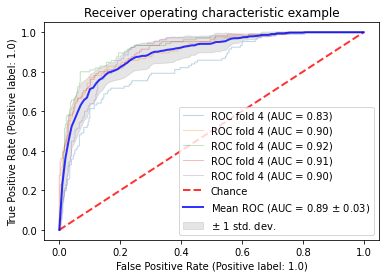

In [ ]:
# the second times, we aplly stratifiedkfold

skf = StratifiedKFold(n_splits=10)
# skf.get_n_splits(X, y)
score=[]
AUC=[]
AUPR=[]
X= np.array(X)
y=np.array(y)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
for train_index, test_index in skf.split(X, y):
    #  print("TRAIN:", train_index, "TEST:", test_index)
     x_train, x_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]
     clf = LogisticRegression(solver="liblinear", class_weight = 'balanced').fit(x_train, y_train)
    #  clf = DecisionTreeClassifier().fit(x_train, y_train)
    #  clf = svm.SVC(kernel="linear", class_weight="balanced").fit(x_train, y_train)
    #  clf = RandomForestClassifier().fit(x_train, y_train)
     viz = plot_roc_curve(clf, x_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
     interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
     interp_tpr[0] = 0.0
     tprs.append(interp_tpr)
     aucs.append(viz.roc_auc)
     y_hat= clf.predict_proba(x_test)[:,1]
    #  y_hat= clf.predict(x_test)
     A = roc_auc_score(y_test, y_hat)
    #  A = roc_auc_score(y_test, clf.decision_function(x_test))
     AUC.append(A)
     print("auc = ", A)
     precision, recall, thresholds = precision_recall_curve(y_test, y_hat)
    #  precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
     PR = auc(recall, precision)
     AUPR.append(PR)
     print("aupr = ", PR)
     sc= clf.score(x_test, y_test)
     score.append(sc)
     print("Score = ", sc)
     print("_____________________")

print("Mean AUC:",mean_cal(AUC))
print("Mean AUPR:",mean_cal(AUPR))
print("Mean Score:",mean_cal(score))
print("________________________")


ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

In [ ]:
# the main test set
X_me = []
Y_me = []
for a in A_test:
  sample = a.split(" ")
  dname =sample[0]
  disname = sample[2].split(".")
  X_me.append(np.concatenate((model1[(dname.rstrip().lower())], model1[(disname[0].lstrip().lower())]), axis=None))
  Y_me.append(1)
for idx, i in I.iterrows():
  if(i.ind_id in my_disease_list and i.drug_id in my_drug_list):
    X_me.append(np.concatenate((model1[i.drug_id.lower()], model1[i.ind_id.lower()]), axis=None))
    # X_me.append((model1[i.drug_id.lower()]- model1[i.ind_id.lower()]))
    Y_me.append(0)

# trainng the model on the train set and evaluate on the test set


clf = LogisticRegression(solver="sag", class_weight = 'balanced', max_iter=10000, penalty='l2').fit(X, y) 
# clf = svm.SVC(kernel="linear", class_weight="balanced").fit(X, y)
# clf = DecisionTreeClassifier().fit(X, y)
# clf = RandomForestClassifier().fit(X, y)

y_hat = clf.predict_proba(X_me)[:,1]
A = roc_auc_score(Y_me, y_hat)

#  A = roc_auc_score(y_test, clf.decision_function(x_test))
print("auc-roc = ", A)
precision, recall, thresholds = precision_recall_curve(Y_me, y_hat)

#  precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
PR = auc(recall, precision)

print("auc-pr = ", PR)
print(average_precision_score(Y_me, clf.predict_proba(X_me)[:,1]))
sc= clf.score(X_me, Y_me)

print("Acc = ", sc)
print(classification_report(Y_me, clf.predict(X_me)))

auc-roc =  0.9352091817845243
auc-pr =  0.936038966900987
0.9364976051007621
Acc =  0.8435374149659864
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        73
           1       0.81      0.89      0.85        74

    accuracy                           0.84       147
   macro avg       0.85      0.84      0.84       147
weighted avg       0.85      0.84      0.84       147



## Undersampling negative data

In [ ]:
neg =hasnt.copy()
neg = neg.sample(n = has.shape[0]) #undersampling negative data randomly for training the model
frames = [has, neg]

f = pd.concat(frames)
X=[]
for idx, row in f.iterrows():
  X.append(np.concatenate((model1[(row.drug_id).lower()], model1[(row.ind_id).lower()]), axis=None))



In [ ]:
y=np.zeros((len(X), ))

for i in range(has.shape[0]):
  y[i]=1


In [ ]:

sauc=[]
sacc=[]
spr=[]
for i in range(5):
  x_train, x_test, y_train, y_test = train_test_split(X, y)
  clf = LogisticRegression(solver="liblinear", max_iter=2000).fit(x_train, y_train)
  # clf = svm.SVC(kernel="linear", class_weight="balanced").fit(x_train, y_train)
  # clf = DecisionTreeClassifier().fit(x_train, y_train)
  # clf = RandomForestClassifier().fit(x_train, y_train)
  # y_hat= clf.predict_proba(x_test)[:, 1]
  y_hat= clf.predict(x_test)
  print("auc = ", roc_auc_score(y_test, y_hat))
  sauc.append(roc_auc_score(y_test, y_hat))
  # print("roc-auc:",roc_auc_score(y_test, clf.decision_function(x_test)))
  # precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
  precision, recall, thresholds = precision_recall_curve(y_test, y_hat)
  print("aupr = ", auc(recall, precision))
  spr.append(auc(recall, precision))
  sacc.append(clf.score(x_test, y_test))
  clf.score(x_test, y_test)
print("____________________\nMean AUC:", mean_cal(sauc), "\n Mean aupr:",mean_cal(spr),"\n Mean acc: ", mean_cal(sacc))

auc =  0.8491529357159433
aupr =  0.8982277388839807
auc =  0.8509032634032634
aupr =  0.9011913353074388
auc =  0.8366666666666667
aupr =  0.8863188283340374
auc =  0.8437934228809634
aupr =  0.8778817096532135
auc =  0.834073641145529
aupr =  0.8940810547239494
____________________
Mean AUC: 0.8429179859624731 
 Mean aupr: 0.8915401333805241 
 Mean acc:  0.8425855513307985


auc =  0.8758760107816711
aupr =  0.866860089863027
Score =  0.8009478672985783
_____________________
auc =  0.8899820305480683
aupr =  0.8945004969194819
Score =  0.8056872037914692
_____________________
auc =  0.929750566893424
aupr =  0.9219523392368678
Score =  0.8904761904761904
_____________________
auc =  0.8738775510204081
aupr =  0.879991865806351
Score =  0.7952380952380952
_____________________
auc =  0.9260317460317461
aupr =  0.9108765045670141
Score =  0.8666666666666667
_____________________
Mean Score: 0.8318032046941999
Mean AUC: 0.8991035810550635
Mean AUPR: 0.8948362592785484
________________________


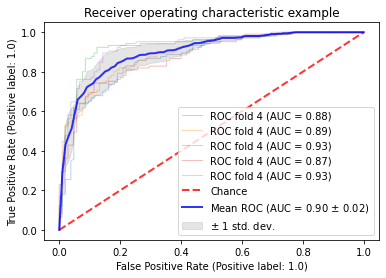

In [ ]:

skf = StratifiedKFold(n_splits=10)
# skf.get_n_splits(X, y)
score=[]
AUC=[]
AUPR=[] 
X= np.array(X)
y=np.array(y)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
for train_index, test_index in skf.split(X, y):
    #  print("TRAIN:", train_index, "TEST:", test_index)
     x_train, x_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]
     clf = LogisticRegression(solver="liblinear", class_weight = 'balanced').fit(x_train, y_train)
    #  clf = svm.SVC(kernel="linear", class_weight="balanced").fit(x_train, y_train)
    #  clf = DecisionTreeClassifier().fit(x_train, y_train)
    #  clf = RandomForestClassifier().fit(x_train, y_train)
     viz = plot_roc_curve(clf, x_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
     interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
     interp_tpr[0] = 0.0
     tprs.append(interp_tpr)
     aucs.append(viz.roc_auc)
     y_hat= clf.predict_proba(x_test)[:,1]
    #  y_hat= clf.predict(x_test)
     A = roc_auc_score(y_test, y_hat)
    #  A = roc_auc_score(y_test, clf.decision_function(x_test))
     AUC.append(A)
     print("auc = ", A)
     precision, recall, thresholds = precision_recall_curve(y_test, y_hat)
    #  precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
     PR = auc(recall, precision)
     AUPR.append(PR)
     print("aupr = ", PR)
     sc= clf.score(x_test, y_test)
     score.append(sc)
     print("Score = ", sc)
     print("_____________________")
print("Mean Score:",mean_cal(score))
print("Mean AUC:",mean_cal(AUC))
print("Mean AUPR:",mean_cal(AUPR))
print("________________________")


ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

In [ ]:
# the main test set
X_me = []
Y_me = []
for a in A_test:
  sample = a.split(" ")
  dname =sample[0]
  disname = sample[2].split(".")
  X_me.append(np.concatenate((model1[(dname.rstrip().lower())], model1[(disname[0].lstrip().lower())]), axis=None))
  Y_me.append(1)
for idx, i in I.iterrows():
  if(i.ind_id in my_disease_list and i.drug_id in my_drug_list):
    X_me.append(np.concatenate((model1[i.drug_id.lower()], model1[i.ind_id.lower()]), axis=None))
    # X_me.append((model1[i.drug_id.lower()]- model1[i.ind_id.lower()]))
    Y_me.append(0)

# trainng the model on the train set and evaluate on the test set


clf = LogisticRegression(solver="sag", class_weight = 'balanced', max_iter=10000, penalty='l2').fit(X, y) 
# clf = svm.SVC(kernel="linear", class_weight="balanced").fit(X, y)
# clf = DecisionTreeClassifier().fit(X, y)
# clf = RandomForestClassifier().fit(X, y)

y_hat = clf.predict_proba(X_me)[:,1]
A = roc_auc_score(Y_me, y_hat)

#  A = roc_auc_score(y_test, clf.decision_function(x_test))
print("auc-roc = ", A)
precision, recall, thresholds = precision_recall_curve(Y_me, y_hat)

#  precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
PR = auc(recall, precision)

print("auc-pr = ", PR)
print(average_precision_score(Y_me, clf.predict_proba(X_me)[:,1]))
sc= clf.score(X_me, Y_me)

print("Acc = ", sc)
print(classification_report(Y_me, clf.predict(X_me)))

auc-roc =  0.9324324324324325
auc-pr =  0.9354848803931286
0.9359336856096917
Acc =  0.8435374149659864
              precision    recall  f1-score   support

           0       0.85      0.84      0.84        73
           1       0.84      0.85      0.85        74

    accuracy                           0.84       147
   macro avg       0.84      0.84      0.84       147
weighted avg       0.84      0.84      0.84       147



## Upsampling positive data

In [ ]:

frames = [has, hasnt]

f = pd.concat(frames)
X=[]
for idx, row in f.iterrows():
  X.append(np.concatenate((model1[(row.drug_id).lower()], model1[(row.ind_id).lower()]), axis=None))



In [ ]:
y=np.zeros((len(X), ))

for i in range(has.shape[0]):
  y[i]=1


In [ ]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
oversample = SMOTE() # over sampling positive by SMOTE
# oversample = RandomOverSampler()
X, y = oversample.fit_resample(X, y)

In [ ]:


sauc=[]
sacc=[]
spr=[]
for i in range(5):
  
  x_train, x_test, y_train, y_test = train_test_split(X, y)
  clf = LogisticRegression(solver="liblinear", max_iter=2000).fit(x_train, y_train)
  # clf = svm.SVC(kernel="linear", class_weight="balanced").fit(x_train, y_train)
  # clf = DecisionTreeClassifier().fit(x_train, y_train)
  # clf = RandomForestClassifier().fit(x_train, y_train)
  y_hat= clf.predict_proba(x_test)[:, 1]
  # y_hat= clf.predict(x_test)
  print("auc = ", roc_auc_score(y_test, y_hat))
  sauc.append(roc_auc_score(y_test, y_hat))
  # print("roc-auc:",roc_auc_score(y_test, clf.decision_function(x_test)))
  # precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
  precision, recall, thresholds = precision_recall_curve(y_test, y_hat)
  print("aupr = ", auc(recall, precision))
  spr.append(auc(recall, precision))
  sacc.append(clf.score(x_test, y_test))
  clf.score(x_test, y_test)
print("____________________\nMean AUC:", mean_cal(sauc), "\n Mean aupr:",mean_cal(spr),"\n Mean acc: ", mean_cal(sacc))

auc =  0.9279590096633612
aupr =  0.9141471434864855
auc =  0.9376749153041686
aupr =  0.9186746582811575
auc =  0.9199455325617114
aupr =  0.9036407982878085
auc =  0.9213555256291558
aupr =  0.9096032360960854
auc =  0.9229162721208678
aupr =  0.9032302571344832
____________________
Mean AUC: 0.925970251055853 
 Mean aupr: 0.9098592186572041 
 Mean acc:  0.851605504587156


auc =  0.8535480004269258
aupr =  0.8391709603771755
Score =  0.7478510028653295
_____________________
auc =  0.9364208832439799
aupr =  0.9328806605582934
Score =  0.8624641833810889
_____________________
auc =  0.9094506613246196
aupr =  0.8965433925056219
Score =  0.8237822349570201
_____________________
auc =  0.9511082567598722
aupr =  0.9500114993511588
Score =  0.8751793400286944
_____________________
auc =  0.9148305503408753
aupr =  0.8807233908703942
Score =  0.8493543758967002
_____________________
Mean Score: 0.8317262274257665
Mean AUC: 0.9130716704192545
Mean AUPR: 0.8998659807325288
________________________


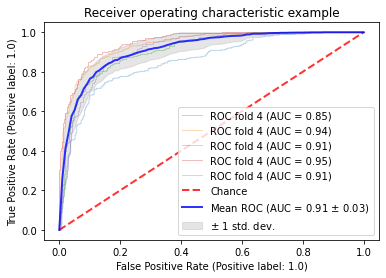

In [ ]:
skf = StratifiedKFold(n_splits=10)
# skf.get_n_splits(X, y)
score=[]
AUC=[]
AUPR=[]
X= np.array(X)
y=np.array(y)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
for train_index, test_index in skf.split(X, y):
    #  print("TRAIN:", train_index, "TEST:", test_index)
     x_train, x_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]
     clf = LogisticRegression(solver="liblinear", class_weight = 'balanced').fit(x_train, y_train)
    #  clf = DecisionTreeClassifier().fit(x_train, y_train)
    #  clf = svm.SVC(kernel="linear", class_weight="balanced").fit(x_train, y_train)
    #  clf = RandomForestClassifier().fit(x_train, y_train)
     viz = plot_roc_curve(clf, x_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
     interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
     interp_tpr[0] = 0.0
     tprs.append(interp_tpr)
     aucs.append(viz.roc_auc)
     y_hat= clf.predict_proba(x_test)[:,1]
    #  y_hat= clf.predict(x_test)
     A = roc_auc_score(y_test, y_hat)
    #  A = roc_auc_score(y_test, clf.decision_function(x_test))
     AUC.append(A)
     print("auc = ", A)
     precision, recall, thresholds = precision_recall_curve(y_test, y_hat)
    #  precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
     PR = auc(recall, precision)
     AUPR.append(PR)
     print("aupr = ", PR)
     sc= clf.score(x_test, y_test)
     score.append(sc)
     print("Score = ", sc)
     print("_____________________")
print("Mean Score:",mean_cal(score))
print("Mean AUC:",mean_cal(AUC))
print("Mean AUPR:",mean_cal(AUPR))
print("________________________")


ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

In [ ]:
# the main test set
X_me = []
Y_me = []
for a in A_test:
  sample = a.split(" ")
  dname =sample[0]
  disname = sample[2].split(".")
  X_me.append(np.concatenate((model1[(dname.rstrip().lower())], model1[(disname[0].lstrip().lower())]), axis=None))
  Y_me.append(1)
for idx, i in I.iterrows():
  if(i.ind_id in my_disease_list and i.drug_id in my_drug_list):
    X_me.append(np.concatenate((model1[i.drug_id.lower()], model1[i.ind_id.lower()]), axis=None))
    # X_me.append((model1[i.drug_id.lower()]- model1[i.ind_id.lower()]))
    Y_me.append(0)

# trainng the model on the train set and evaluate on the test set


clf = LogisticRegression(solver="sag", class_weight = 'balanced', max_iter=10000, penalty='l2').fit(X, y) 
# clf = svm.SVC(kernel="linear", class_weight="balanced").fit(X, y)
# clf = DecisionTreeClassifier().fit(X, y)
# clf = RandomForestClassifier().fit(X, y)

y_hat = clf.predict_proba(X_me)[:,1]
A = roc_auc_score(Y_me, y_hat)

#  A = roc_auc_score(y_test, clf.decision_function(x_test))
print("auc-roc = ", A)
precision, recall, thresholds = precision_recall_curve(Y_me, y_hat)

#  precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
PR = auc(recall, precision)

print("auc-pr = ", PR)
print(average_precision_score(Y_me, clf.predict_proba(X_me)[:,1]))
sc= clf.score(X_me, Y_me)

print("Acc = ", sc)
print(classification_report(Y_me, clf.predict(X_me)))

auc-roc =  0.9353942984079971
auc-pr =  0.9356810665636106
0.9361494874827805
Acc =  0.8503401360544217
              precision    recall  f1-score   support

           0       0.87      0.82      0.85        73
           1       0.83      0.88      0.86        74

    accuracy                           0.85       147
   macro avg       0.85      0.85      0.85       147
weighted avg       0.85      0.85      0.85       147



## First oversample, Next Undersample

In [84]:

frames = [has, hasnt]

f = pd.concat(frames)
X=[]
for idx, row in f.iterrows():
  X.append(np.concatenate((model1[(row.drug_id).lower()], model1[(row.ind_id).lower()]), axis=None))



In [85]:
y=np.zeros((len(X), ))

for i in range(has.shape[0]):
  y[i]=1


In [86]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
over = SMOTE(0.9)
# over = RandomOverSampler(0.9)
under = RandomUnderSampler()
X, y = over.fit_resample(X,y)
print(len(X))
X,y = under.fit_resample(X,y)
print(len(X))

3587
3398


In [87]:
sauc=[]
sacc=[]
spr=[]
for i in range(5):
  x_train, x_test, y_train, y_test = train_test_split(X, y)
  clf = LogisticRegression(solver="sag", max_iter=2000).fit(x_train, y_train)
  # clf = svm.SVC(kernel="linear", class_weight="balanced").fit(x_train, y_train)
  # clf = DecisionTreeClassifier().fit(x_train, y_train)
  # clf = RandomForestClassifier().fit(x_train, y_train)
  y_hat= clf.predict_proba(x_test)[:, 1]
  # y_hat= clf.predict(x_test)
  print("auc = ", roc_auc_score(y_test, y_hat))
  sauc.append(roc_auc_score(y_test, y_hat))
  # print("roc-auc:",roc_auc_score(y_test, clf.decision_function(x_test)))
  # precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
  precision, recall, thresholds = precision_recall_curve(y_test, y_hat)
  print("aupr = ", auc(recall, precision))
  spr.append(auc(recall, precision))
  sacc.append(clf.score(x_test, y_test))
  clf.score(x_test, y_test)
print("____________________\nMean AUC:", mean_cal(sauc), "\n Mean aupr:",mean_cal(spr),"\n Mean acc: ", mean_cal(sacc))

auc =  0.931541019955654
aupr =  0.9217092175614312
auc =  0.9278825647417255
aupr =  0.9175124484995066
auc =  0.9218196925633568
aupr =  0.9034441427593656
auc =  0.926346817670558
aupr =  0.9230102027015479
auc =  0.9172396802196828
aupr =  0.9137503442962187
____________________
Mean AUC: 0.9249659550301954 
 Mean aupr: 0.915885271163614 
 Mean acc:  0.8510588235294116


auc =  0.8883910034602076
aupr =  0.8619294219806679
Score =  0.8147058823529412
_____________________
auc =  0.9255709342560554
aupr =  0.9195100450905687
Score =  0.8411764705882353
_____________________
auc =  0.9405709342560553
aupr =  0.9436341686971389
Score =  0.8529411764705882
_____________________
auc =  0.9323529411764706
aupr =  0.8984897420951431
Score =  0.8911764705882353
_____________________
auc =  0.9399653979238753
aupr =  0.9221935909719287
Score =  0.861764705882353
_____________________
auc =  0.9001384083044983
aupr =  0.8914825610059562
Score =  0.8235294117647058
_____________________
auc =  0.9412110726643599
aupr =  0.9139544537576471
Score =  0.861764705882353
_____________________
auc =  0.9348788927335641
aupr =  0.9227281223238456
Score =  0.861764705882353
_____________________
auc =  0.9273929690219284
aupr =  0.8991101932379078
Score =  0.8495575221238938
_____________________
auc =  0.9429168116950922
aupr =  0.9443347520590181
Score =  0.882005899705

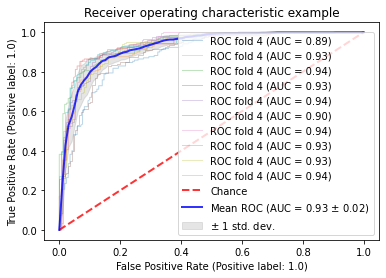

In [88]:
skf = StratifiedKFold(n_splits=10)
# skf.get_n_splits(X, y)
score=[]
AUC=[]
AUPR=[]
X= np.array(X)
y=np.array(y)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
for train_index, test_index in skf.split(X, y):
    #  print("TRAIN:", train_index, "TEST:", test_index)
     x_train, x_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]
     clf = LogisticRegression(solver="liblinear", class_weight = 'balanced', max_iter=10000).fit(x_train, y_train)
    #  clf = DecisionTreeClassifier().fit(x_train, y_train)
    #  clf = svm.SVC(kernel="linear", class_weight="balanced").fit(x_train, y_train)
    #  clf = RandomForestClassifier().fit(x_train, y_train)
     viz = plot_roc_curve(clf, x_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
     interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
     interp_tpr[0] = 0.0
     tprs.append(interp_tpr)
     aucs.append(viz.roc_auc)
     y_hat= clf.predict_proba(x_test)[:,1]
    #  y_hat= clf.predict(x_test)
     A = roc_auc_score(y_test, y_hat)
    #  A = roc_auc_score(y_test, clf.decision_function(x_test))
     AUC.append(A)
     print("auc = ", A)
     precision, recall, thresholds = precision_recall_curve(y_test, y_hat)
    #  precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
     PR = auc(recall, precision)
     AUPR.append(PR)
     print("aupr = ", PR)
     sc= clf.score(x_test, y_test)
     score.append(sc)
     print("Score = ", sc)
     print("_____________________")
print("Mean Score:",mean_cal(score))
print("Mean AUC:",mean_cal(AUC))
print("Mean AUPR:",mean_cal(AUPR))
print("________________________")


ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

In [89]:
# the main test set
X_me = []
Y_me = []
for a in A_test:
  sample = a.split(" ")
  dname =sample[0]
  disname = sample[2].split(".")
  X_me.append(np.concatenate((model1[(dname.rstrip().lower())], model1[(disname[0].lstrip().lower())]), axis=None))
  Y_me.append(1)
for idx, i in I.iterrows():
  if(i.ind_id in my_disease_list and i.drug_id in my_drug_list):
    X_me.append(np.concatenate((model1[i.drug_id.lower()], model1[i.ind_id.lower()]), axis=None))
    # X_me.append((model1[i.drug_id.lower()]- model1[i.ind_id.lower()]))
    Y_me.append(0)

# trainng the model on the train set and evaluate on the test set


# clf = LogisticRegression(solver="sag", class_weight = 'balanced', max_iter=10000, penalty='l2').fit(X, y) 
# clf = svm.SVC(kernel="linear", class_weight="balanced").fit(X, y)
clf = DecisionTreeClassifier().fit(X, y)
# clf = RandomForestClassifier().fit(X, y)

y_hat = clf.predict_proba(X_me)[:,1]
A = roc_auc_score(Y_me, y_hat)

#  A = roc_auc_score(y_test, clf.decision_function(x_test))
print("auc-roc = ", A)
precision, recall, thresholds = precision_recall_curve(Y_me, y_hat)

#  precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
PR = auc(recall, precision)

print("auc-pr = ", PR)
print(average_precision_score(Y_me, clf.predict_proba(X_me)[:,1]))
sc= clf.score(X_me, Y_me)

print("Acc = ", sc)
print(classification_report(Y_me, clf.predict(X_me)))

auc-roc =  0.7933125433125432
auc-pr =  0.8524558791619452
0.7470555970778987
Acc =  0.7960526315789473
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        78
           1       0.86      0.69      0.77        74

    accuracy                           0.80       152
   macro avg       0.81      0.79      0.79       152
weighted avg       0.81      0.80      0.79       152



#Test the model on 
rf+ovun+5+150+concat


In [ ]:

frames = [has, hasnt]

f = pd.concat(frames)
X=[]
for idx, row in f.iterrows():
  X.append(np.concatenate((model1[(row.drug_id).lower()], model1[(row.ind_id).lower()]), axis=None))



In [ ]:
y=np.zeros((len(X), ))

for i in range(has.shape[0]):
  y[i]=1


In [ ]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
over = SMOTE(0.9)
# over = RandomOverSampler(0.9)
under = RandomUnderSampler()
X, y = over.fit_resample(X,y)
print(len(X))
X,y = under.fit_resample(X,y)
print(len(X))

3592
3402


In [ ]:
X_me = []
Y_me = []
for a in A_test:
  sample = a.split(" ")
  dname =sample[0]
  disname = sample[2].split(".")
  X_me.append(np.concatenate((model1[(dname.rstrip().lower())], model1[(disname[0].lstrip().lower())]), axis=None))
  # X_me.append((model1[(dname.rstrip().lower())]- model1[(disname[0].lstrip().lower())]))
  Y_me.append(1)
for idx, i in I.iterrows():
  X_me.append(np.concatenate((model1[i.drug_id.lower()], model1[i.ind_id.lower()]), axis=None))
  # X_me.append((model1[i.drug_id.lower()]- model1[i.ind_id.lower()]))
  Y_me.append(0)

In [ ]:
clf = LogisticRegression(solver="sag", class_weight = 'balanced', max_iter=10000, penalty='l2').fit(X, y) # penalti should be changed
# clf = svm.SVC(kernel="linear", class_weight="balanced").fit(X, y)
# clf = DecisionTreeClassifier().fit(X, y)
# clf = RandomForestClassifier().fit(X, y)

y_hat = clf.predict_proba(X_me)[:,1]
A = roc_auc_score(Y_me, y_hat)

#  A = roc_auc_score(y_test, clf.decision_function(x_test))
print("auc = ", A)
precision, recall, thresholds = precision_recall_curve(Y_me, y_hat)

#  precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
PR = auc(recall, precision)

print("aupr = ", PR)
print(average_precision_score(Y_me, clf.predict_proba(X_me)[:,1]))
sc= clf.score(X_me, Y_me)

print("Score = ", sc)
print(classification_report(Y_me, clf.predict(X_me)))

auc =  0.8782051282051282
aupr =  0.8343833283168789
0.8415509167417345
Score =  0.7948717948717948
              precision    recall  f1-score   support

           0       0.77      0.85      0.80        78
           1       0.83      0.74      0.78        78

    accuracy                           0.79       156
   macro avg       0.80      0.79      0.79       156
weighted avg       0.80      0.79      0.79       156



auc =  0.8790269559500329
aupr =  0.8366357006988545
Score =  0.7884615384615384
_____________________
auc =  0.8782051282051282
aupr =  0.8361861068845176
Score =  0.782051282051282
_____________________
auc =  0.8800131492439185
aupr =  0.8368043618774486
Score =  0.7948717948717948
_____________________
auc =  0.8754109138724523
aupr =  0.8342868654068767
Score =  0.8012820512820513
_____________________
auc =  0.8791913214990138
aupr =  0.8349816682940633
Score =  0.7884615384615384
_____________________
auc =  0.8775476660092045
aupr =  0.8338139409397762
Score =  0.8012820512820513
_____________________
auc =  0.8780407626561473
aupr =  0.8347037378335262
Score =  0.7884615384615384
_____________________
auc =  0.8767258382642997
aupr =  0.8338727169823523
Score =  0.7884615384615384
_____________________
auc =  0.8767258382642998
aupr =  0.8349353096805588
Score =  0.7948717948717948
_____________________
auc =  0.8777120315581854
aupr =  0.8349957473632158
Score =  0.7756410256

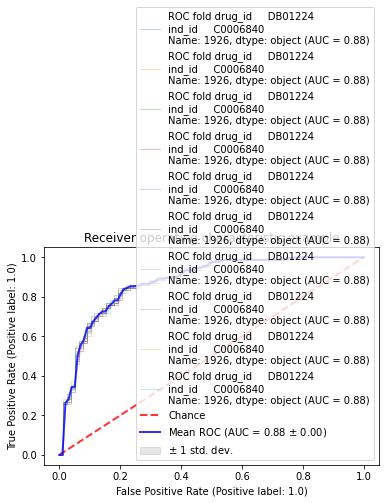

In [ ]:
skf = StratifiedKFold(n_splits=10)
# skf.get_n_splits(X, y)
score=[]
AUC=[]
AUPR=[]
X= np.array(X)
y=np.array(y)
tprs = []
aucs = []
final_result = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
for train_index, test_index in skf.split(X, y):
    #  print("TRAIN:", train_index, "TEST:", test_index)
     x_train, x_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]
     clf = LogisticRegression(solver="sag", class_weight = 'balanced', max_iter=10000).fit(x_train, y_train)
    #  clf = DecisionTreeClassifier().fit(x_train, y_train)
    #  clf = svm.SVC(kernel="linear", class_weight="balanced").fit(x_train, y_train)
    #  clf = RandomForestClassifier().fit(x_train, y_train)
     viz = plot_roc_curve(clf, X_me, Y_me,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
     interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
     interp_tpr[0] = 0.0
     tprs.append(interp_tpr)
     aucs.append(viz.roc_auc)
     y_hat= clf.predict_proba(X_me)[:,1]
    #  y_hat= clf.predict(X_me)
     final_result.append(y_hat)
     
     A = roc_auc_score(Y_me, y_hat)
    #  A = roc_auc_score(y_test, clf.decision_function(x_test))
     AUC.append(A)
     print("auc = ", A)
     precision, recall, thresholds = precision_recall_curve(Y_me, y_hat)
    #  precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
     PR = auc(recall, precision)
     AUPR.append(PR)
     print("aupr = ", PR)
     sc= clf.score(X_me, Y_me)
     score.append(sc)
     print("Score = ", sc)
     print("_____________________")
print("Mean Score:",mean_cal(score))
print("Mean AUC:",mean_cal(AUC))
print("Mean AUPR:",mean_cal(AUPR))
print("________________________")


ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)'  % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

# Evaluation on Skin related disease

We consider atopic eczema and contact dermatities as test case to show how much it can generalized

For this purpose, we should design our DDKG again without considering negative or positive associations

In [ ]:
skin_disease=['C0011615']
# skin_disease=['C0011616']

In [ ]:
ass = pd.read_csv("my_repodb.txt") 
ass.set_index("Unnamed: 0", inplace=True)
disgenet = pd.read_csv("Gen-Dis-association-Disgenet-2022.csv")

# making the drug and disease lists
my_disease_list = list(set(ass.ind_id))
my_drug_list = list(set(ass.drug_id))
drugs=list(set(ass.drug_id))
disgenet = disgenet.loc[disgenet['diseaseId'].isin(my_disease_list)]
my_disease_list = list(set(disgenet.diseaseId))
ass = ass.loc[ass['ind_id'].isin(my_disease_list)]
my_drug_list = list(set(ass.drug_id))

A=[]
for ix, row in ass.iterrows():
  text = str(row.drug_id)+" has_indicated "+str(row.ind_id)+". "
  A.append(text)

associations = A.copy()

# making the drug and disease lists


In [ ]:

# making the relation of diseases: has_geneid, has_class, has_semantic, has_type

C=[]
num1=0
num2=0
num3=0
num4=0
for idx, row in disgenet.iterrows():
  # if row.diseaseId in my_disease_list:
      semtype = "_".join(row.diseaseSemanticType.split())
      clas = row.diseaseClass.split(";")
      text1 =str(row.diseaseId)+" has_geneid "+str(row.geneSymbol)+". "
      num1+=1
      text2 =str(row.diseaseId)+" has_type "+str(row.diseaseType)+". "
      num2+=1
      text3 =str(row.diseaseId)+" has_semantic "+str(semtype)+". "
      num3+=1
      C.append(text1)
      C.append(text2)
      C.append(text3)
      num4+=len(clas)
      for cl in clas:
        text =str(row.diseaseId)+" has_class "+str(cl)+". "
        C.append(text)

Disease=""
for c in C:
  Disease= Disease+c


making the drug relations: has_sideeffect, has_target, has_domain, has_atccode, has_chemicalstructure

In [ ]:
# has_target relation. data is collected using DrugBank
T=[]
target= pd.read_csv("my_target.txt")
target.set_index("Unnamed: 0", inplace=True)
for idx, row in target.iterrows():
  for c in target.columns:
    if row[c] ==1 :
      text =str(idx)+" has_target "+str(c)+". "
      T.append(text)
target=""
for c in T:
  target= target+c

In [ ]:
# has_domain relation. data is collected using UniProt
D=[]
dom= pd.read_csv("my_domain.txt")
dom.set_index("Unnamed: 0", inplace=True)
for idx, row in dom.iterrows():
  for c in dom.columns:
    if row[c] ==1 :
      text =str(idx)+" has_domain "+str(c)+". "
      D.append(text)

domain=""
for c in D:
  domain= domain+c

In [ ]:
# has_chemical relation. data is collected using Pubchem
C=[]
finger= pd.read_csv("my_finger.txt")
finger.set_index("Unnamed: 0", inplace=True)
for idx, row in finger.iterrows():
  for c in finger.columns:
    if row[c] ==1 :
      text =str(idx)+" has_chemical S"+str(c)+". "
      C.append(text)
chemical=""
for c in C:
  chemical= chemical+c

In [ ]:
# has_atc_code relation. data is collected using Sider4.1

ATC=[]
atc= pd.read_csv("my_ATC.txt")
atc.set_index("Unnamed: 0", inplace=True)
for idx, row in atc.iterrows():
  for c in atc.columns:
    if row[c] == 1 and (len(c)==4 or len(c)==1 or len(c)==3 or len(c)==5): # we consider first 4 level of ATC code
      text =str(idx)+" has_atc_code "+str(c)+". "
      ATC.append(text)
atccode=""
for c in ATC:
  atccode= atccode+c

In [ ]:
# has_sideeffect relation. Date is collected using Sider4.1
S=[]
side= pd.read_csv("my_sideeffect.txt")
side.set_index("Unnamed: 0", inplace=True)
for idx, row in side.iterrows():
  for c in side.columns:
    if row[c] ==1 :
      text =str(idx)+" has_sideeffect "+str(c)+". "
      S.append(text)

Extracting drug-disease associations

Positive data: Known drug-disease associations

Negative data: a subset of unknown drug-disease associations that disease is an adverse drug reaction and common with our side effects

In [ ]:
has = pd.read_csv("my_repodb.txt") # Positive data: Known Drug-Disease associations
has.set_index("Unnamed: 0", inplace=True)
has = has.drop(['drug_name', 'ind_name','NCT','status', 'phase',
       'DetailedStatus'], axis=1)
has = has.loc[has['ind_id'].isin(my_disease_list)]


hasnt = pd.read_csv("my_only_negatives.txt") # Negative data: Unknown Drug-Disease associations when disease is adverse drug reaction
hasnt.set_index("Unnamed: 0", inplace=True)
hasnt = hasnt.rename(columns={"Not_indicated_for":"ind_id", "Drug_id": "drug_id"})
hasnt = hasnt.loc[hasnt['ind_id'].isin(my_disease_list)]

In [ ]:
A_test=[]
for d in my_drug_list:
  text = str(d)+" has_indicated C0011615. " 
  if text in associations:
    A.remove(text)
    A_test.append(text)
ass="" # making the new associations for training the models
for c in A:
  ass= ass+c

In [ ]:

print("The number of all known drug disease associations in our dataset: ",(has.shape))

I=[]
for idx, row in has.iterrows():
  text=str(row.drug_id)+" has_indicated "+str(row.ind_id)+". "
  if text in A_test: # Extracting test associations from positive data
    I.append(idx)
has = has.drop(index=I, axis=0)
print("The number of  known drug disease associations without positive test set:",has.shape)

The number of all known drug disease associations in our dataset:  (748, 2)
The number of  known drug disease associations without positive test set: (733, 2)


In [ ]:

I=[]
u=0

hasnt_test_idx=[]
for idx, row in hasnt.iterrows():
 if row.ind_id == "C0011615":
  #  print(row)
   text = str(row.drug_id)+" has_sideeffect C0011615. "
   if(text in S):
     hasnt_test_idx.append(idx)
     I.append(row)
     S.remove(text)
     u+=1

hasnt = hasnt.drop(index=hasnt_test_idx, axis=0)
hasnt.shape

I=pd.DataFrame(I)

side=""
for c in S:
  side= side+c

##Word2Vec implementation


first, we make the file of our DDKG


In [ ]:
data=[]
sets=[chemical, target, side, domain, atccode, ass, Disease]

for s in sets:
  for i in sent_tokenize(s):
      temp = []
      # tokenize the sentence into words
      for j in word_tokenize(i):
          temp.append(j.lower())
      data.append(temp)

In [ ]:
model1 = gensim.models.Word2Vec(min_count = 1, alpha=0.001, size = 700, window = 2, iter=2000, sg=0)
model1.build_vocab(data, progress_per=10000)
model1.train(data, total_examples=model1.corpus_count, epochs=500, report_delay=1)
model1.init_sims(replace=True)

In [ ]:
def mean_cal(K):
  sum=0
  for k in K:
    sum= sum+k
  return(sum/len(K))

## training a logistic regression

In [ ]:
frames = [has, hasnt]

f = pd.concat(frames)
X=[]
for idx, row in f.iterrows():
  X.append(np.concatenate((model1[(row.drug_id).lower()], model1[(row.ind_id).lower()]), axis=None))
y=np.zeros((len(X), ))

for i in range(has.shape[0]):
  y[i]=1


In [ ]:
over = SMOTE(0.9)
# over = RandomOverSampler(0.9)
under = RandomUnderSampler()
X, y = over.fit_resample(X,y)
print(len(X))
X,y = under.fit_resample(X,y)
print(len(X))

3659
3466


In [ ]:
X_me = []
Y_me = []

for a in A_test:
  sample = a.split(" ")
  dname =sample[0]
  disname = sample[2].split(".")
  X_me.append(np.concatenate((model1[(dname.rstrip().lower())], model1[(disname[0].lstrip().lower())]), axis=None))
  # X_me.append((model1[(dname.rstrip().lower())]- model1[(disname[0].lstrip().lower())]))
  Y_me.append(1)
for idx, i in I.iterrows():
  X_me.append(np.concatenate((model1[i.drug_id.lower()], model1[i.ind_id.lower()]), axis=None))
  # X_me.append((model1[i.drug_id.lower()]- model1[i.ind_id.lower()]))
  Y_me.append(0)

In [ ]:
clf = LogisticRegression(solver="sag", class_weight = 'balanced', max_iter=10000, penalty='l2').fit(X, y) # penalti should be changed
# clf = svm.SVC(kernel="linear", class_weight="balanced").fit(X, y)
# clf = DecisionTreeClassifier().fit(X, y)
# clf = RandomForestClassifier().fit(X, y)

y_hat = clf.predict_proba(X_me)[:,1]
A = roc_auc_score(Y_me, y_hat)

#  A = roc_auc_score(y_test, clf.decision_function(x_test))
print("auc = ", A)
precision, recall, thresholds = precision_recall_curve(Y_me, y_hat)

#  precision, recall, thresholds = precision_recall_curve(y_test, clf.decision_function(x_test))
PR = auc(recall, precision)

print("aupr = ", PR)


auc =  0.9583333333333334
aupr =  0.8891733683101969


Now, we calculate the association score between our disease and all drugs to find the first 10 reltaed drugs to them

In [ ]:
skin_disease=['C0011615']

SCOR_PD=pd.DataFrame(columns={"Dis_id", "Drug_id", "Score"}) # To save association score
for dis in skin_disease:
  for drug in my_drug_list:
    x=np.concatenate((model1[(drug).lower()], model1[(dis).lower()]), axis=None)
    # x= x.reshape(-1, 1)
    s = clf.predict_proba([x])[:,1]
    # s = clf.predict([x])
    df2 = {"Dis_id":dis, "Drug_id":drug, "Score":s}
    SCOR_PD = SCOR_PD.append(df2, ignore_index = True)


In [ ]:
top10_drugs=[]  
for dis in skin_disease:
  dis_pd = SCOR_PD[SCOR_PD.Dis_id == dis]
  m = dis_pd.Score.max()
  dis_pd = dis_pd.sort_values(by='Score', ascending=False) # First we sort the scores
  dis_pd = dis_pd.head(10) # Extract the top 10
  sum=0 
  
  for idx, row in dis_pd.iterrows():
    text = str(row.Drug_id)+' has_indicated '+str(dis)+'. '   # Check is there any association between them in our dataset or not
    if text in associations:
      sum+=1 # if there is, we count it
    all=0
    for d in my_drug_list:  # Here we find the number of all related drugs to the disease
      text = str(d)+' has_indicated '+str(dis)+'. '
      if text in associations:
        all+=1
        # print(text)
  if(all!=0):
    print("All:", all, "Sum:", sum)
    if(all>10):
      top10_drugs.append(sum/10)  
    else:
      top10_drugs.append(sum/all)
  else:
    top10_drugs.append(0)

All: 15 Sum: 5


###find unknown associations


In [ ]:
for id in skin_disease:
  dis_pd = SCOR_PD[SCOR_PD.Dis_id==id]
  dis_pd = dis_pd.sort_values(by='Score', ascending=False)
  dis_pd = dis_pd.head(10)
  for idx, row in dis_pd.iterrows():
    text = str(row.Drug_id)+' has_indicated '+str(row.Dis_id)+'. '
    if not(text in associations):
      print(text)


DB00259 has_indicated C0011615. 
DB00324 has_indicated C0011615. 
DB00634 has_indicated C0011615. 
DB00838 has_indicated C0011615. 
DB00394 has_indicated C0011615. 


# Covid Drugs

In [ ]:
ass = pd.read_csv("my_repodb.txt") 
ass.set_index("Unnamed: 0", inplace=True)
disgenet = pd.read_csv("Gen-Dis-association-Disgenet-2022 - CORONA VIRUS INFECTION.csv")

# making the drug and disease lists
my_disease_list = list(set(ass.ind_id))
my_disease_list.append("C0206750")
my_drug_list = list(set(ass.drug_id))
drugs=list(set(ass.drug_id))
disgenet = disgenet.loc[disgenet['diseaseId'].isin(my_disease_list)]
my_disease_list = list(set(disgenet.diseaseId))
ass = ass.loc[ass['ind_id'].isin(my_disease_list)]
my_drug_list = list(set(ass.drug_id))


covid_drugs= pd.read_csv("Covid-19 drugs from drugbank.csv")
covid_drugs

In [ ]:
i=0
my_covid_drug = []
for d in covid_drugs.drug_id:
  if d in my_drug_list:
    my_covid_drug.append(d)
    i+=1
print(i)



In [ ]:
has = pd.read_csv("my_repodb.txt") # Positive data: Known Drug-Disease associations
has.set_index("Unnamed: 0", inplace=True)
has = has.drop(['drug_name', 'ind_name','NCT','status', 'phase',
       'DetailedStatus'], axis=1)
has = has.loc[has['ind_id'].isin(my_disease_list)]


hasnt = pd.read_csv("my_only_negatives.txt") # Negative data: Unknown Drug-Disease associations when disease is adverse drug reaction
hasnt.set_index("Unnamed: 0", inplace=True)
hasnt = hasnt.rename(columns={"Not_indicated_for":"ind_id", "Drug_id": "drug_id"})
hasnt = hasnt.loc[hasnt['ind_id'].isin(my_disease_list)]


In [ ]:


# making the relation of diseases: has_geneid, has_class, has_semantic, has_type

C=[]
num1=0
num2=0
num3=0
num4=0
for idx, row in disgenet.iterrows():
  # if row.diseaseId in my_disease_list:
      semtype = "_".join(row.diseaseSemanticType.split())
      clas = row.diseaseClass.split(";")
      text1 =str(row.diseaseId)+" has_geneid "+str(row.geneSymbol)+". "
      num1+=1
      text2 =str(row.diseaseId)+" has_type "+str(row.diseaseType)+". "
      num2+=1
      text3 =str(row.diseaseId)+" has_semantic "+str(semtype)+". "
      num3+=1
      C.append(text1)
      C.append(text2)
      C.append(text3)
      num4+=len(clas)
      for cl in clas:
        text =str(row.diseaseId)+" has_class "+str(cl)+". "
        C.append(text)

Disease=""
for c in C:
  Disease= Disease+c


making the drug relations: has_sideeffect, has_target, has_domain, has_atccode, has_chemicalstructure

In [ ]:
# has_target relation. data is collected using DrugBank
T=[]
target= pd.read_csv("my_target.txt")
target.set_index("Unnamed: 0", inplace=True)
for idx, row in target.iterrows():
  for c in target.columns:
    if row[c] ==1 :
      text =str(idx)+" has_target "+str(c)+". "
      T.append(text)
target=""
for c in T:
  target= target+c

In [ ]:
# has_domain relation. data is collected using UniProt
D=[]
dom= pd.read_csv("my_domain.txt")
dom.set_index("Unnamed: 0", inplace=True)
for idx, row in dom.iterrows():
  for c in dom.columns:
    if row[c] ==1 :
      text =str(idx)+" has_domain "+str(c)+". "
      D.append(text)

domain=""
for c in D:
  domain= domain+c


In [ ]:
# has_chemical relation. data is collected using Pubchem
C=[]
finger= pd.read_csv("my_finger.txt")
finger.set_index("Unnamed: 0", inplace=True)
for idx, row in finger.iterrows():
  for c in finger.columns:
    if row[c] ==1 :
      text =str(idx)+" has_chemical S"+str(c)+". "
      C.append(text)
chemical=""
for c in C:
  chemical= chemical+c

In [ ]:
# has_atc_code relation. data is collected using Sider4.1

ATC=[]
atc= pd.read_csv("my_ATC.txt")
atc.set_index("Unnamed: 0", inplace=True)
for idx, row in atc.iterrows():
  for c in atc.columns:
    if row[c] == 1 and (len(c)==4 or len(c)==1 or len(c)==3 or len(c)==5): # we consider first 4 level of ATC code
      text =str(idx)+" has_atc_code "+str(c)+". "
      ATC.append(text)
atccode=""
for c in ATC:
  atccode= atccode+c

In [ ]:
# has_sideeffect relation. Date is collected using Sider4.1
S=[]
side= pd.read_csv("my_sideeffect.txt")
side.set_index("Unnamed: 0", inplace=True)
for idx, row in side.iterrows():
  for c in side.columns:
    if row[c] ==1 :
      text =str(idx)+" has_sideeffect "+str(c)+". "
      S.append(text)

In [ ]:
A=[]
for ix, row in ass.iterrows():
  text = str(row.drug_id)+" has_indicated "+str(row.ind_id)+". "
  A.append(text)

ass="" # making the new associations for training the models
for c in A:
  ass= ass+c

side=""
for c in S:
  side= side+c

I = hasnt

## Word2Vec

In [ ]:

data=[]
sets=[chemical, target, side, domain, atccode, ass, Disease]

for s in sets:
  for i in sent_tokenize(s):
      temp = []
      # tokenize the sentence into words
      for j in word_tokenize(i):
          temp.append(j.lower())
      data.append(temp)

In [ ]:
word_freq = defaultdict(int)
for sent in data:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

In [ ]:
model1 = gensim.models.Word2Vec(min_count = 1, alpha=0.001, size = 700, window = 2, iter=2000, sg=0)
model1.build_vocab(data, progress_per=10000)
model1.train(data, total_examples=model1.corpus_count, epochs=500, report_delay=1)
model1.init_sims(replace=True)

## Test on COVID-19

In [ ]:
frames = [has, hasnt]

f = pd.concat(frames)
X=[]
for idx, row in f.iterrows():
  X.append(np.concatenate((model1[(row.drug_id).lower()], model1[(row.ind_id).lower()]), axis=None))
y=np.zeros((len(X), ))

for i in range(has.shape[0]):
  y[i]=1


In [ ]:
over = SMOTE(0.9)
# over = RandomOverSampler(0.9)
under = RandomUnderSampler()
X, y = over.fit_resample(X,y)
print(len(X))
X,y = under.fit_resample(X,y)
print(len(X))

In [ ]:
X_me = []
Y_me = []

for a in A_test:
  sample = a.split(" ")
  dname =sample[0]
  disname = sample[2].split(".")
  X_me.append(np.concatenate((model1[(dname.rstrip().lower())], model1[(disname[0].lstrip().lower())]), axis=None))
  # X_me.append((model1[(dname.rstrip().lower())]- model1[(disname[0].lstrip().lower())]))
  Y_me.append(1)
for idx, i in I.iterrows():
  X_me.append(np.concatenate((model1[i.drug_id.lower()], model1[i.ind_id.lower()]), axis=None))
  # X_me.append((model1[i.drug_id.lower()]- model1[i.ind_id.lower()]))
  Y_me.append(0)

In [ ]:
clf = LogisticRegression(solver="sag", class_weight = 'balanced', max_iter=10000, penalty='l2').fit(X, y) # penalti should be changed


Now, we calculate the association score between our disease and all drugs to find the first 10 reltaed drugs to them

In [ ]:
covid_disease=['C0206750']

SCOR_PD=pd.DataFrame(columns={"Dis_id", "Drug_id", "Score"}) # To save association score
for dis in covid_disease:
  for drug in my_drug_list:
    x=np.concatenate((model1[(drug).lower()], model1[(dis).lower()]), axis=None)
    # x= x.reshape(-1, 1)
    s = clf.predict_proba([x])[:,1]
    # s = clf.predict([x])
    df2 = {"Dis_id":dis, "Drug_id":drug, "Score":s}
    SCOR_PD = SCOR_PD.append(df2, ignore_index = True)


In [ ]:
SCOR_PD = SCOR_PD.sort_values(by='Score', ascending=False)
SCOR_PD

,Score,Dis_id,Drug_id
84,[0.966568243958105],C0206750,DB00663
328,[0.9641678658635396],C0206750,DB00240
238,[0.9621519180869536],C0206750,DB00324
32,[0.9604907096508107],C0206750,DB00259
186,[0.9596351838219059],C0206750,DB00223
...,...,...,...
24,[0.20267179723169682],C0206750,DB00188
196,[0.19662031258509288],C0206750,DB00413
219,[0.19529571178530059],C0206750,DB00268
156,[0.16703778980002382],C0206750,DB00215


In [ ]:
df = SCOR_PD.loc[SCOR_PD["Drug_id"].isin(my_covid_drug)]
df

,Score,Dis_id,Drug_id
82,[0.9252709530295148],C0206750,DB01234
10,[0.9084346898709634],C0206750,DB00959
69,[0.8754586677460166],C0206750,DB00608
108,[0.8705758796599655],C0206750,DB01394
353,[0.7372971537664909],C0206750,DB00207
61,[0.6238683309087277],C0206750,DB01050
392,[0.6216779080024117],C0206750,DB08868
